<a href="https://colab.research.google.com/github/Codypanh/DATAFLOW-M1/blob/main/B%E1%BA%A3n_sao_c%E1%BB%A7a_%5BINSIGHTS_FLOW%5D_V%C3%92NG_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TỔNG QUAN**

**Nội dung bài toán:** Đề bài xoay quanh việc tối ưu hóa hệ thống đề xuất sản phẩm cho một ngân hàng bán lẻ và tài chính cá nhân. Hiện tại, hệ thống gợi ý chưa phân bổ đồng đều, dẫn đến tình trạng một số khách hàng nhận quá nhiều đề xuất, trong khi nhiều khách hàng khác lại không nhận được gợi ý phù hợp. Điều này ảnh hưởng đến trải nghiệm khách hàng và mức độ gắn kết với ngân hàng. Mục tiêu là xây dựng một mô hình dự đoán sử dụng dữ liệu hành vi tài chính để cá nhân hóa đề xuất sản phẩm, giúp tối ưu hóa chiến lược bán chéo và gia tăng doanh thu. Dữ liệu gồm 1,5 năm giao dịch của khách hàng, với nhiệm vụ dự đoán các sản phẩm mới họ có thể mua vào tháng 5/2016 của tập dữ liệu.



**Lựa chọn mô hình:** Hệ thống gợi ý của nhóm sử dụng mô hình cây phân loại tăng cường theo độ dốc (Gradient Boosted Classification Trees), với XGBoost là công cụ chính. XGBoost là một thư viện học máy mạnh mẽ, có hiệu suất cao, hỗ trợ tính toán song song và cung cấp điều chuẩn L1/L2 giúp cải thiện độ chính xác của mô hình.


# **ĐỌC DỮ LIỆU**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import datetime
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
import joblib

In [ ]:
# Importing  Dataset
data_link = 'https://drive.google.com/file/d/15PnuZd0Q1n9b-MlSK3_TEhFSRVejkMXL/view?usp=drive_link'
file_id = data_link.split("/")[-2]
!gdown "https://drive.google.com/uc?export=download&id={file_id}" -O final.csv
df = pd.read_csv("final.csv")

Downloading...
From (original): https://drive.google.com/uc?export=download&id=15PnuZd0Q1n9b-MlSK3_TEhFSRVejkMXL
From (redirected): https://drive.google.com/uc?export=download&id=15PnuZd0Q1n9b-MlSK3_TEhFSRVejkMXL&confirm=t&uuid=1021d879-1d41-4e0e-8252-f9c746904048
To: /content/final.csv
100% 775M/775M [00:04<00:00, 192MB/s] 


<ipython-input-6-5a54b95747b2>:5: DtypeWarning: Columns (11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("final.csv")


In [ ]:
df['Total'] = df.loc[:, 'saving_account':'direct_debit'].sum(axis=1)

In [ ]:
#Đổi tên các cột dữ liệu
column_mapping = {
    'fecha_dato': 'Date',
    'ncodpers': 'Customer_code',
    'ind_empleado': 'Employee_index',
    'pais_residencia': 'Country_residence',
    'sexo': 'Sex',
    'age': 'Age',
    'fecha_alta': 'First_holder_date',
    'ind_nuevo': 'New_customer_index',
    'antiguedad': 'Customer_seniority_(months)',
    'indrel': 'Primary_customer',
    'ult_fec_cli_1t': 'Last_date_as_primary_customer',
    'indrel_1mes': 'Customer_type_at_beginning_of_month',
    'tiprel_1mes': 'Customer_relation_type_at_beginning_of_month',
    'indresi': 'Residence_index',
    'indext': 'Foreigner_index',
    'conyuemp': 'Spouse_index',
    'canal_entrada': 'Customer_join_channel',
    'indfall': 'Deceased_index',
    'tipodom': 'Address_type',
    'cod_prov': 'Province_code',
    'nomprov': 'Province_name',
    'ind_actividad_cliente': 'Activity_index',
    'renta': 'Household_income',
    'segmento': 'Customer_segmentation',
    'ind_ahor_fin_ult1': 'Saving_Account',
    'ind_aval_fin_ult1': 'Guarantees',
    'ind_cco_fin_ult1': 'Current_Accounts',
    'ind_cder_fin_ult1': 'Derivada_Account',
    'ind_cno_fin_ult1': 'Payroll_Account',
    'ind_ctju_fin_ult1': 'Junior_Account',
    'ind_ctma_fin_ult1': 'Más_particular_Account',
    'ind_ctop_fin_ult1': 'Particular_Account',
    'ind_ctpp_fin_ult1': 'Particular_Plus_Account',
    'ind_deco_fin_ult1': 'Short-term_deposits',
    'ind_deme_fin_ult1': 'Medium-term _deposits',
    'ind_dela_fin_ult1': 'Long-term_deposits',
    'ind_ecue_fin_ult1': 'E-account',
    'ind_fond_fin_ult1': 'Funds',
    'ind_hip_fin_ult1': 'Mortgage',
    'ind_plan_fin_ult1': 'Pensions',
    'ind_pres_fin_ult1': 'Loans',
    'ind_reca_fin_ult1': 'Taxes',
    'ind_tjcr_fin_ult1': 'Credit_Card',
    'ind_valo_fin_ult1': 'Securities',
    'ind_viv_fin_ult1': 'Home_Account',
    'ind_nomina_ult1': 'Payroll',
    'ind_nom_pens_ult1': 'Pensions',
    'ind_recibo_ult1': 'Direct_Debit'
}
df = df.rename(columns=column_mapping) # Remove inplace=True and reassign the result
column_names = df.columns
print(column_names)

Index(['date', 'customer_code', 'employee_index', 'country_residence',
       'gender', 'Age', 'date_joined', 'new_customer_index',
       'customer_seniority', 'customer_type', 'last_date_as_primary',
       'customer_type_beginning', 'customer_relation_type', 'residence_index',
       'foreigner_index', 'spouse_index', 'customer_entry_channel',
       'deceased_index', 'address_type', 'province_code', 'province_name',
       'customer_activity_index', 'household_income', 'customer_segment',
       'saving_account', 'guarantees', 'current_accounts', 'Derivada_Account',
       'Payroll_Account', 'Junior_Account', 'Más_particular_Account',
       'Particular_Account', 'Particular_Plus_Account', 'Short-term_deposits',
       'medium_term_deposits', 'Long-term_deposits', 'e_account',
       'investment_funds', 'mortgage', 'pensions', 'loans', 'taxes',
       'credit_card', 'securities', 'home_account', 'salary', 'pension_salary',
       'direct_debit', 'Total'],
      dtype='object')


# **PHÂN TÍCH KHÁM PHÁ (EDA)**

##Tổng quan dữ liệu

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4621976 entries, 0 to 4621975
Data columns (total 49 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   date                     object 
 1   customer_code            int64  
 2   employee_index           object 
 3   country_residence        object 
 4   gender                   object 
 5   Age                      int64  
 6   date_joined              object 
 7   new_customer_index       float64
 8   customer_seniority       int64  
 9   customer_type            float64
 10  last_date_as_primary     object 
 11  customer_type_beginning  object 
 12  customer_relation_type   object 
 13  residence_index          object 
 14  foreigner_index          object 
 15  spouse_index             object 
 16  customer_entry_channel   object 
 17  deceased_index           object 
 18  address_type             float64
 19  province_code            float64
 20  province_name            object 
 21  customer

In [ ]:
df.describe()

,customer_code,Age,new_customer_index,customer_seniority,customer_type,address_type,province_code,customer_activity_index,household_income,saving_account,...,pensions,loans,taxes,credit_card,securities,home_account,salary,pension_salary,direct_debit,Total
count,4.621976e+06,4.621976e+06,4.621976e+06,4.621976e+06,4.621976e+06,4621976.0,4.602042e+06,4.621976e+06,3.519074e+06,4.621976e+06,...,4.621976e+06,4.621976e+06,4.621976e+06,4.621976e+06,4.621976e+06,4.621976e+06,4.621976e+06,4.621976e+06,4.621976e+06,4.621976e+06
mean,8.744346e+05,4.000392e+01,7.139522e-02,7.556665e+01,1.184106e+00,1.0,2.654828e+01,4.242530e-01,1.340896e+05,8.416314e-05,...,7.965857e-03,2.159033e-03,4.835551e-02,3.757679e-02,2.319787e-02,3.225677e-03,4.915733e-02,5.328089e-02,1.193027e-01,1.327279e+00
std,4.459240e+05,1.721746e+01,2.574839e-01,1.741831e+03,4.243643e+00,0.0,1.283434e+01,4.942291e-01,2.321057e+05,9.173662e-03,...,8.889547e-02,4.641522e-02,2.145163e-01,1.901704e-01,1.505315e-01,5.670337e-02,2.161964e-01,2.245931e-01,3.241443e-01,1.471264e+00
min,1.588900e+04,2.000000e+00,0.000000e+00,-9.999990e+05,1.000000e+00,1.0,1.000000e+00,0.000000e+00,1.202730e+03,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.803090e+05,2.400000e+01,0.000000e+00,2.100000e+01,1.000000e+00,1.0,1.500000e+01,0.000000e+00,6.849568e+04,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.623570e+05,3.800000e+01,0.000000e+00,5.200000e+01,1.000000e+00,1.0,2.800000e+01,0.000000e+00,1.015017e+05,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.256050e+06,5.000000e+01,0.000000e+00,1.330000e+02,1.000000e+00,1.0,3.500000e+01,1.000000e+00,1.555426e+05,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
max,1.553689e+06,1.640000e+02,1.000000e+00,2.560000e+02,9.900000e+01,1.0,5.200000e+01,1.000000e+00,2.889440e+07,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.500000e+01


In [ ]:
def get_null_summary(df):
    """
    Trả về DataFrame chứa số lượng giá trị NaN của từng cột,
    chỉ giữ lại những cột có ít nhất một giá trị NaN.
    """
    df_null_counts = df.isnull().sum()
    df_filtered = df_null_counts[df_null_counts > 0].sort_values(ascending=False)
    return pd.DataFrame(df_filtered, columns=['Missing Values'])

get_null_summary(df)

,Missing Values
spouse_index,4621397
last_date_as_primary,4613293
household_income,1102902
customer_segment,40359
customer_entry_channel,38825
customer_type_beginning,24232
customer_relation_type,24232
province_code,19934
province_name,19934
gender,25


<ipython-input-12-6e05b2d68501>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing.values[:15], y=missing.index[:15], palette='viridis')


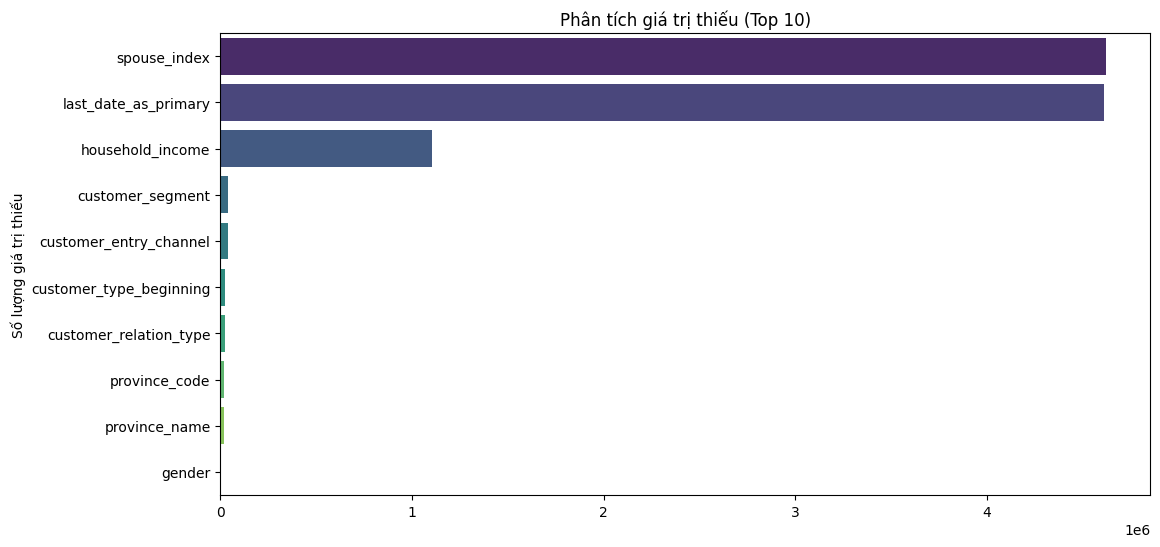

In [ ]:
# 2. Phân tích giá trị thiếu
def missing_values(df):
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    if not missing.empty:
        plt.figure(figsize=(12,6))
        sns.barplot(x=missing.values[:15], y=missing.index[:15], palette='viridis')
        plt.xticks(rotation=0, fontsize=10)
        plt.ylabel("Số lượng giá trị thiếu")
        plt.title("Phân tích giá trị thiếu (Top 10)")
        plt.show()

missing_values(df)

##Phân phối dữ liệu

###DEF FUNCTION

In [ ]:
import matplotlib.pyplot as plt

def plot_bar_chart(df, column_name):
    value_counts = df[column_name].value_counts()

    plt.figure(figsize=(10, 6))
    bars = plt.bar(value_counts.index, value_counts.values, color='skyblue', edgecolor='black')

    # Hiển thị giá trị trên đầu mỗi cột
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05*yval, str(yval), ha='center', va='bottom', fontsize=10)

    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.title(f"Distribution of {column_name}")

    # Giảm y_label bằng cách sử dụng log scale hoặc giới hạn trục
    plt.yscale('log')  # Nếu dữ liệu chênh lệch quá lớn
    # plt.ylim(0, max(value_counts.values) * 1.1)  # Hoặc đặt giới hạn trục y tùy chỉnh

    plt.xticks(rotation=0)  # Xoay nhãn trục x nếu cần
    plt.grid(axis='y', alpha=0.5)
    plt.show()


In [ ]:
def plot_top_histogram(df, column_name, top_n=10):
    """
    Vẽ histogram của top N giá trị phổ biến nhất trong một cột của DataFrame.

    Args:
    - df: DataFrame chứa dữ liệu.
    - column_name: Tên cột cần vẽ histogram.
    - top_n: Số lượng giá trị phổ biến nhất cần hiển thị (mặc định là 10).
    """
    value_counts = df[column_name].dropna().value_counts().nlargest(top_n)  # Lấy top N giá trị phổ biến nhất

    plt.figure(figsize=(10, 6))
    bars = plt.bar(value_counts.index, value_counts.values, color='skyblue', edgecolor='black')

    # Hiển thị giá trị trên đầu mỗi cột
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05*yval, str(yval),
                 ha='center', va='bottom', fontsize=10, fontstyle='italic')  # Chữ nghiêng

    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.title(f"Top {top_n} Most Frequent Values in {column_name}")
    plt.xticks(rotation=45, fontstyle='italic')  # Xoay nhãn trục X nghiêng 45 độ
    plt.yscale('log')  # Nếu dữ liệu chênh lệch quá lớn
    plt.grid(axis='y', alpha=0.5)

    plt.show()

# Gọi hàm với DataFrame của bạn
# plot_top_histogram(df, 'tên_cột')


In [ ]:
def plot_distribution(df, column, bins=None):
    """
    Args:
    - df: DataFrame chứa dữ liệu.
    - column: Tên cột chứa thông tin cần vẽ phân phối.
    - bins: Số lượng khoảng phân chia trong histogram (mặc định là None, tự động xác định).
    """
    plt.figure(figsize=(10, 6))

    # Xác định số bins nếu không có giá trị
    if bins is None:
        bins = int(df[column].nunique())  # Lấy số lượng giá trị duy nhất làm bins

    # Vẽ histogram và lấy giá trị tần suất
    counts, edges, bars = plt.hist(df[column], bins=bins, edgecolor='black', alpha=0.7, color='skyblue')

    plt.xlabel(column.capitalize())
    plt.ylabel("Frequency")
    plt.title(f"{column.capitalize()} Distribution")
    plt.grid(axis='y', alpha=0.5)
    plt.show()

# Gọi hàm với DataFrame của bạn
# plot_distribution(df, 'customer_type_beginning', bins=10)

In [ ]:
def plot_stacked_barh(df_a, a, b):
    df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='viridis')
    plt.title(f"Popularity of Products by {a} and {b}", fontsize=20)
    plt.xlabel("Number of customers", fontsize=17)
    plt.ylabel("Product Names", fontsize=17)
    plt.legend(df_a.columns, prop={'size':15})
    plt.show()

In [ ]:
def prepare_dataframe(df, group_col1, group_col2, start_col, end_col):
    df_a = df.loc[:, [group_col1, group_col2]].join(df.loc[:, start_col:end_col])
    df_a = df_a.groupby([group_col1, group_col2]).sum()
    df_a = df_a.T
    return df_a

def prepare_dataframe2(df, group_col1, start_col, end_col):
    df_a = df.loc[:, [group_col1]].join(df.loc[:, start_col:end_col])
    df_a = df_a.groupby([group_col1]).sum()
    df_a = df_a.T
    return df_a

def prepare_dataframe_exclude(df, group_col1, group_col2, start_col, end_col, exclude):
    df_a = df.loc[:, [group_col1, group_col2]].join(df.loc[:, start_col:end_col])
    df_a = df_a.groupby([group_col1, group_col2]).sum()
    df_a = df_a.T
    df_a = df_a.drop(exclude, axis=1).T
    return df_a

In [ ]:
import pandas as pd

def group_and_sum(df, income_col, start_col, end_col, bins, labels):
    """
    Bin a continuous income column into categories, group by these bins, and sum columns within a specified range.

    Parameters:
        df (pd.DataFrame): Input DataFrame
        income_col (str): Column name containing household income
        start_col (str): Starting column name for summation
        end_col (str): Ending column name for summation
        bins (list): List of bin edges for income segmentation
        labels (list): Corresponding labels for the bins

    Returns:
        pd.DataFrame: Grouped and summed DataFrame
    """
    if income_col not in df.columns:
        raise ValueError(f"Column '{income_col}' not found in DataFrame.")

    if start_col not in df.columns or end_col not in df.columns:
        raise ValueError(f"Start column '{start_col}' or end column '{end_col}' not found in DataFrame.")

    if len(labels) != len(bins) - 1:
        raise ValueError("Number of labels must be equal to the number of bins minus one.")

    df['income_bin'] = pd.cut(df[income_col], bins=bins, labels=labels, right=False)

    print(df[['household_income', 'income_bin']].drop_duplicates())  # Debugging step to check binning

    start_idx = df.columns.get_loc(start_col)
    end_idx = df.columns.get_loc(end_col) + 1
    sum_cols = df.columns[start_idx:end_idx]

    grouped_df = df.groupby('income_bin')[sum_cols].sum().reset_index()

    return grouped_df


In [ ]:
def plot_stacked_barh(df_a, a):
    df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='viridis')
    plt.title(f"Popularity of Products by {a}", fontsize=20)
    plt.xlabel("Number of customers", fontsize=17)
    plt.ylabel("Product Names", fontsize=17)
    plt.legend(df_a.columns, prop={'size':15})
    plt.show()

def plot_stacked_barh2(df_a, a, b):
    df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='viridis')
    plt.title(f"Popularity of Products by {a} & {b}", fontsize=20)
    plt.xlabel("Number of customers", fontsize=17)
    plt.ylabel("Product Names", fontsize=17)
    plt.legend(df_a.columns, prop={'size':15})
    plt.show()

In [ ]:
def groupby2(df, group_col, agg_col, agg_func):
    """
    Group by a specified column and aggregate another column with a chosen function, then sort by the grouped column.

    Parameters:
    df (pd.DataFrame): Input DataFrame
    group_col (str): Column name to group by
    agg_col (str): Column name to aggregate
    agg_func (str or function): Aggregation function

    Returns:
    pd.DataFrame: Grouped and aggregated DataFrame, sorted by the group column
    """
    result = df.groupby(group_col, as_index=False)[agg_col].agg(agg_func)
    result = result.sort_values(by=group_col)
    return result

In [ ]:
def plot_boxplot(df, column_name):
    """
    Hàm vẽ boxplot cho một cột cụ thể trong DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame chứa dữ liệu.
        column_name (str): Tên cột muốn vẽ boxplot.
    """
    # Kiểm tra nếu cột không tồn tại
    if column_name not in df.columns:
        print(f"Lỗi: Cột '{column_name}' không tồn tại trong DataFrame.")
        return

    # Kiểm tra nếu cột không phải là kiểu số
    if not pd.api.types.is_numeric_dtype(df[column_name]):
        print(f"Lỗi: Cột '{column_name}' không phải là kiểu số, không thể vẽ boxplot.")
        return

    # Vẽ boxplot
    plt.figure(figsize=(8, 5))
    sns.boxplot(y=df[column_name])
    plt.title(f"Boxplot của {column_name}", fontsize=14, fontweight='bold')
    plt.ylabel(column_name, fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Cách sử dụng:
# plot_boxplot(df, 'customer_activity_index')  # Ví dụ vẽ boxplot cho cột 'customer_activity_index'


###EDA Phân phối các cột

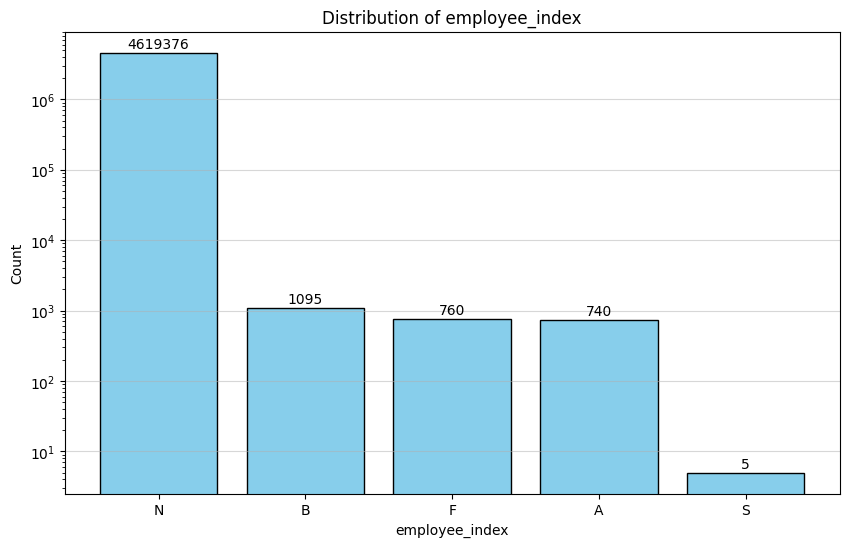

In [ ]:
#df['ind_empleado'] = df['ind_empleado'].astype(str)

plot_bar_chart(df, 'employee_index')

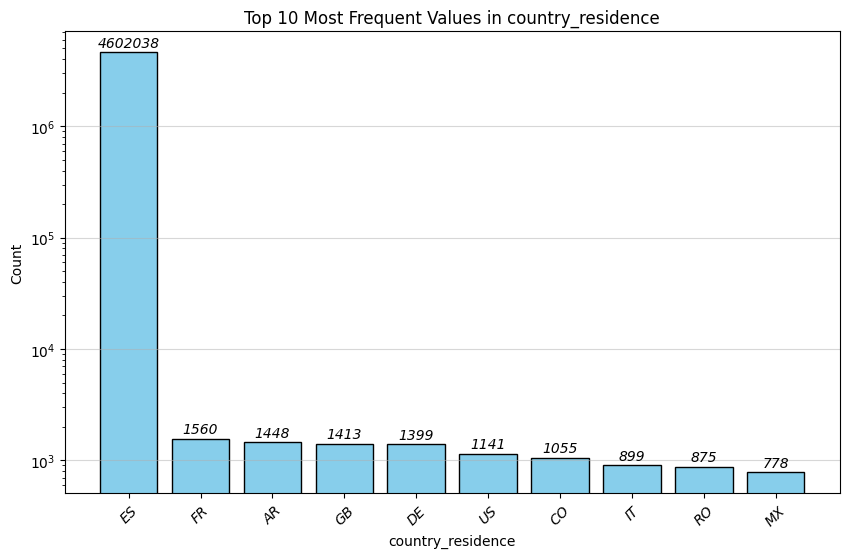

In [ ]:
plot_top_histogram(df, 'country_residence')

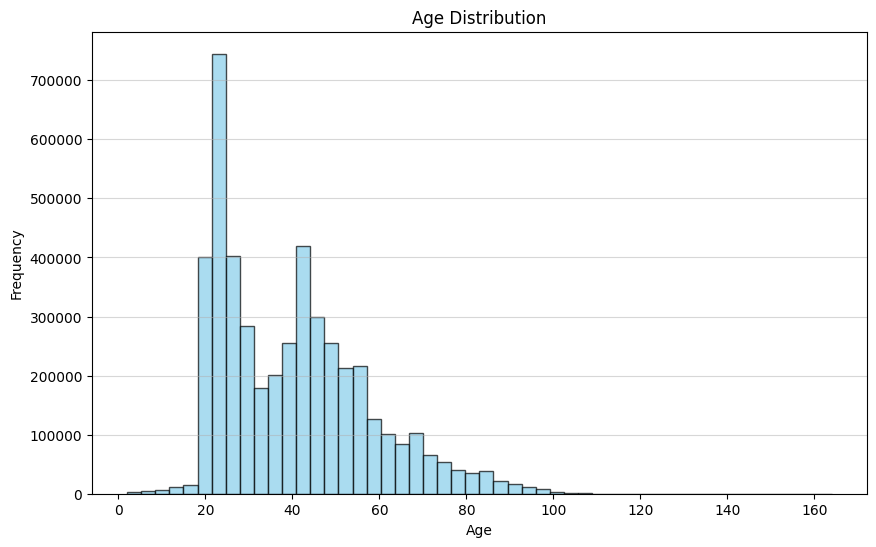

In [ ]:
plot_distribution(df, 'Age', bins = 50)

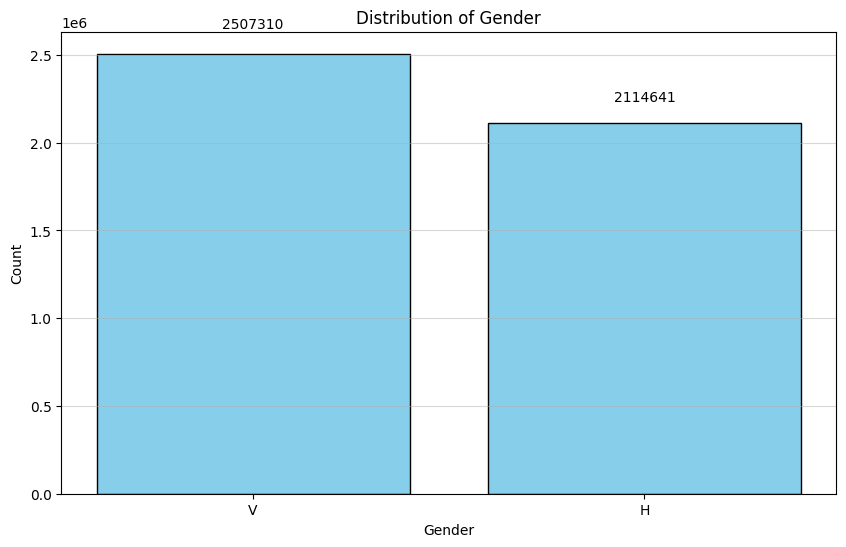

In [ ]:
import matplotlib.pyplot as plt

# Giả sử df là DataFrame đã có sẵn với một cột giới tính, ví dụ 'gender'
value_counts = df['gender'].value_counts()

plt.figure(figsize=(10, 6))
bars = plt.bar(value_counts.index, value_counts.values, color='skyblue', edgecolor='black')

# Hiển thị giá trị trên đầu mỗi cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05*yval, str(yval), ha='center', va='bottom', fontsize=10)

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Gender')

plt.xticks(rotation=0)  # Xoay nhãn trục x nếu cần
plt.grid(axis='y', alpha=0.5)
plt.show()


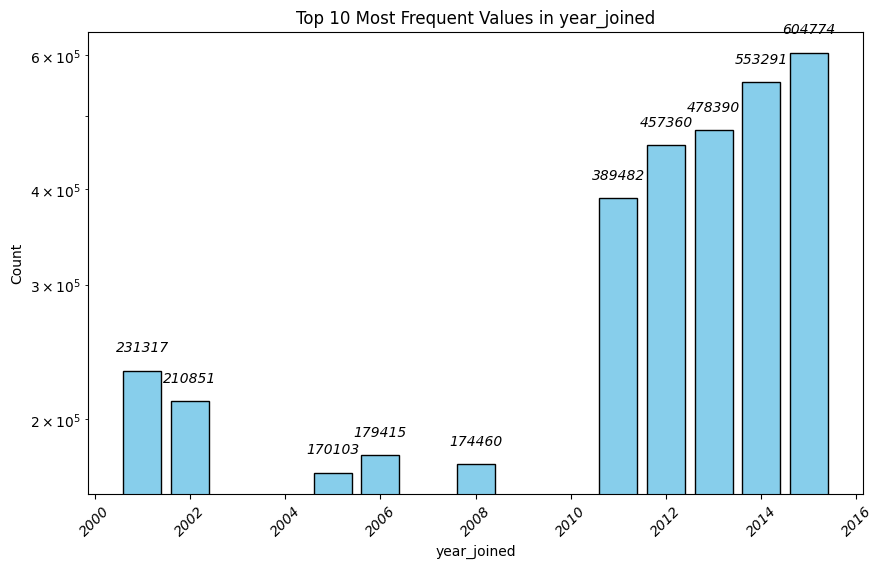

In [ ]:
# Chuyển đổi cột 'fecha_alta' thành kiểu datetime, bỏ qua lỗi nếu có
df['date_joined'] = pd.to_datetime(df['date_joined'], errors='coerce')

# Trích xuất năm từ cột 'fecha_alta' và lưu vào cột mới 'year_alta'
df['year_joined'] = df['date_joined'].dt.year

# Kiểm tra kết quả
plot_top_histogram(df, 'year_joined')

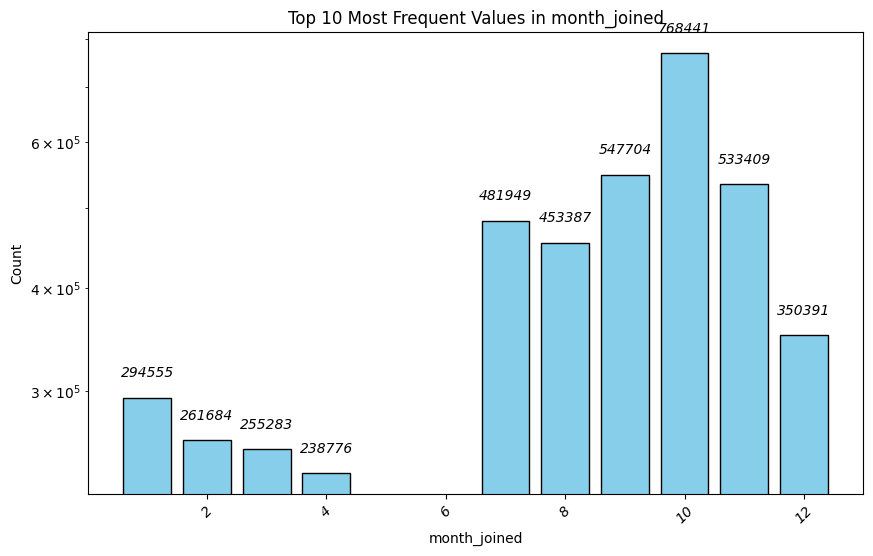

In [ ]:
# Chuyển đổi cột 'fecha_alta' thành kiểu datetime, bỏ qua lỗi nếu có
df['date_joined'] = pd.to_datetime(df['date_joined'], errors='coerce')

# Trích xuất năm từ cột 'fecha_alta' và lưu vào cột mới 'year_alta'
df['month_joined'] = df['date_joined'].dt.month

# Kiểm tra kết quả
plot_top_histogram(df, 'month_joined')

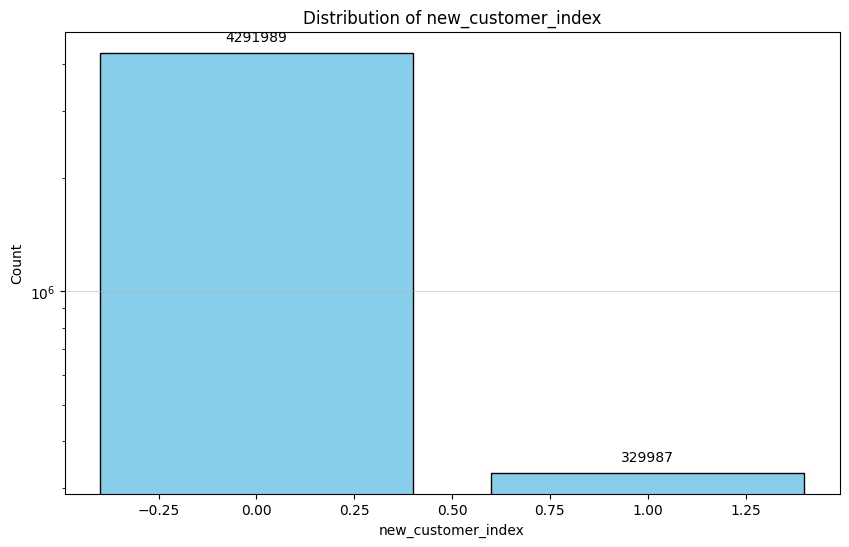

In [ ]:
plot_bar_chart(df, 'new_customer_index')

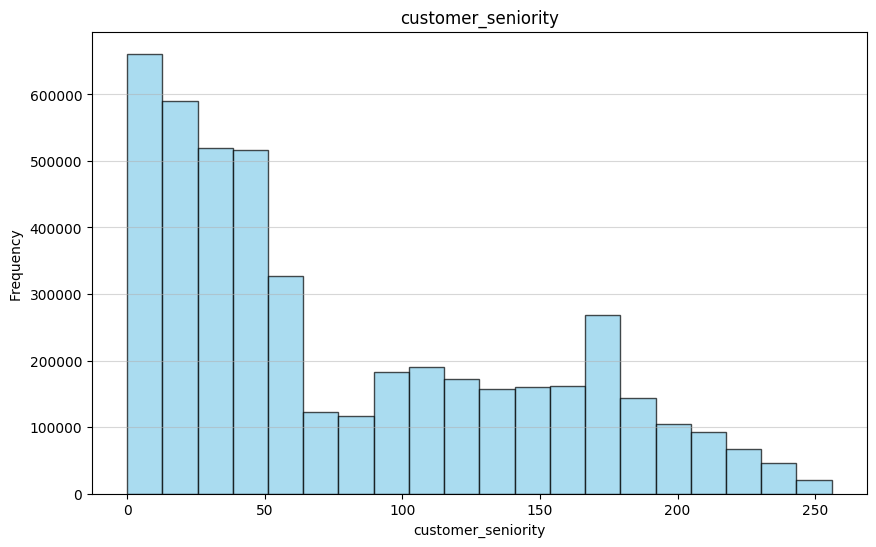

In [ ]:

df1 = df[df['customer_seniority'] >= 0]

plt.figure(figsize=(10, 6))

    # Vẽ histogram và lấy giá trị tần suất
counts, edges, bars = plt.hist(df1['customer_seniority'], bins=20, edgecolor='black', alpha=0.7, color='skyblue')


plt.xlabel("customer_seniority")
plt.ylabel("Frequency ")
plt.title("customer_seniority")
plt.grid(axis='y', alpha=0.5)
plt.show()


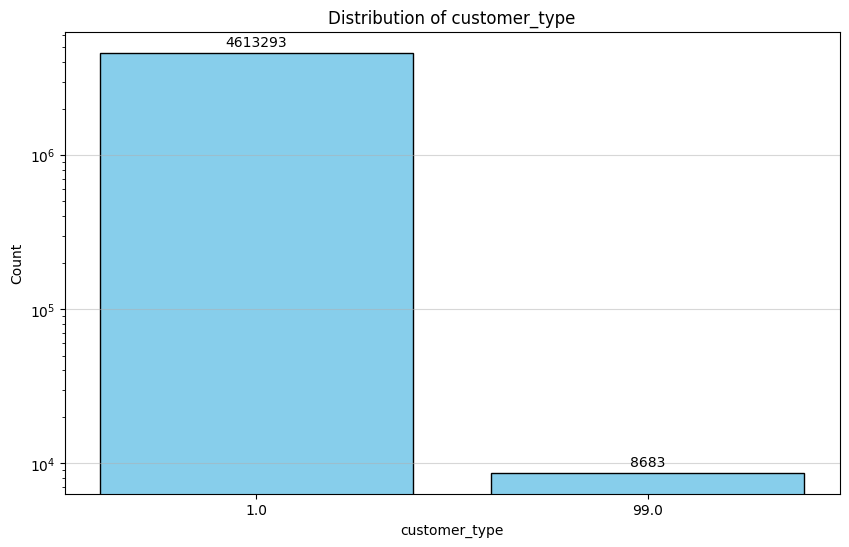

In [ ]:
df['customer_type'] = df['customer_type'].astype(str)
plot_bar_chart(df, 'customer_type')

In [ ]:
df = df1.copy()

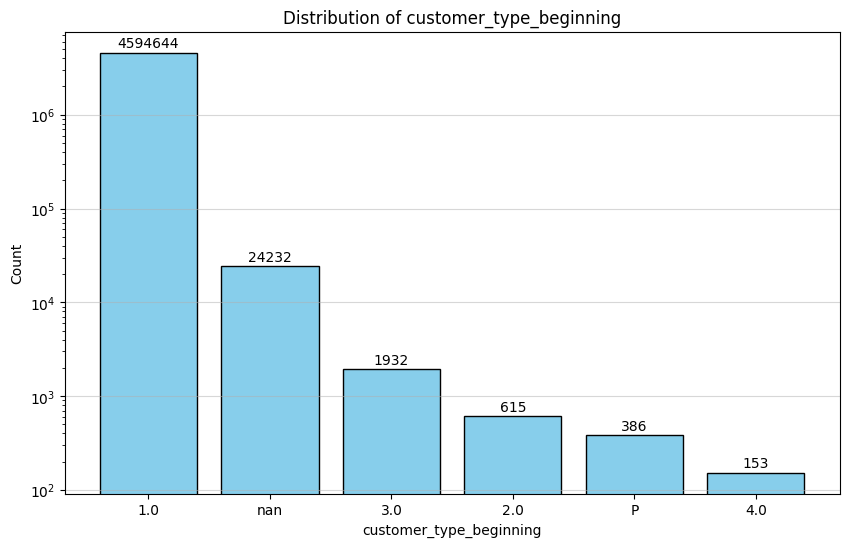

In [ ]:
# Gán giá trị 'P' thành 5
df['customer_type_beginning'] = df['customer_type_beginning'].replace('P', '5.0')


# Chuyển toàn bộ cột sang kiểu int
df['customer_type_beginning'] = pd.to_numeric(df['customer_type_beginning'], errors='coerce').dropna().astype(int)
# Chuyển giá trị 5 trở lại thành 'P'



df['customer_type_beginning'] = df['customer_type_beginning'].astype(str)
df['customer_type_beginning'] = df['customer_type_beginning'].replace('5.0', 'P')
plot_bar_chart(df, 'customer_type_beginning')


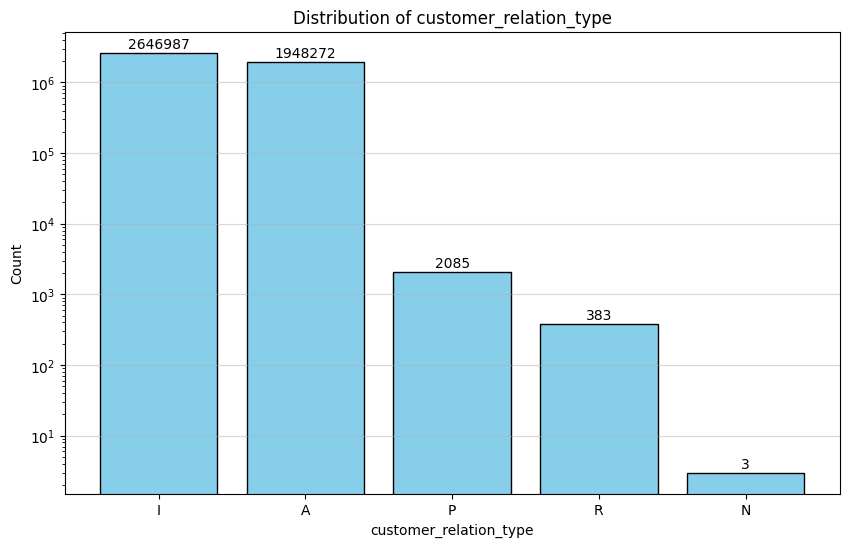

In [ ]:
plot_bar_chart(df, 'customer_relation_type')

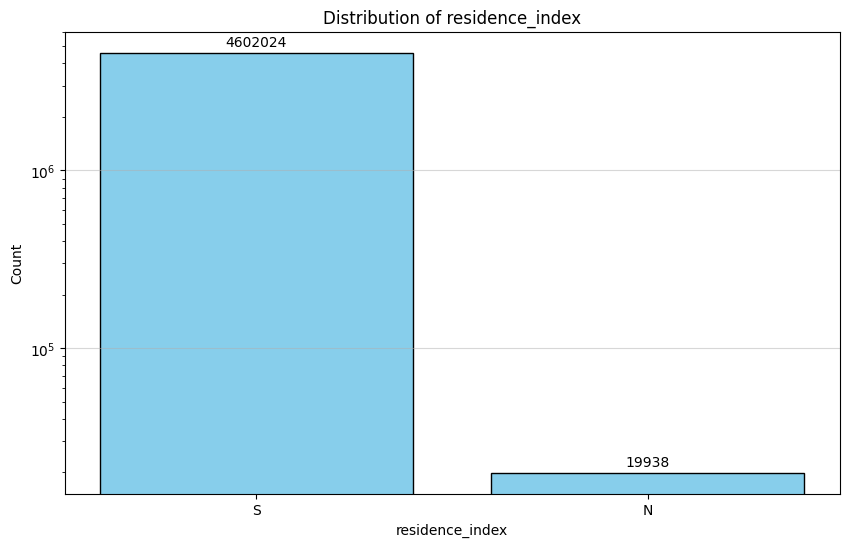

In [ ]:
plot_bar_chart(df, 'residence_index')

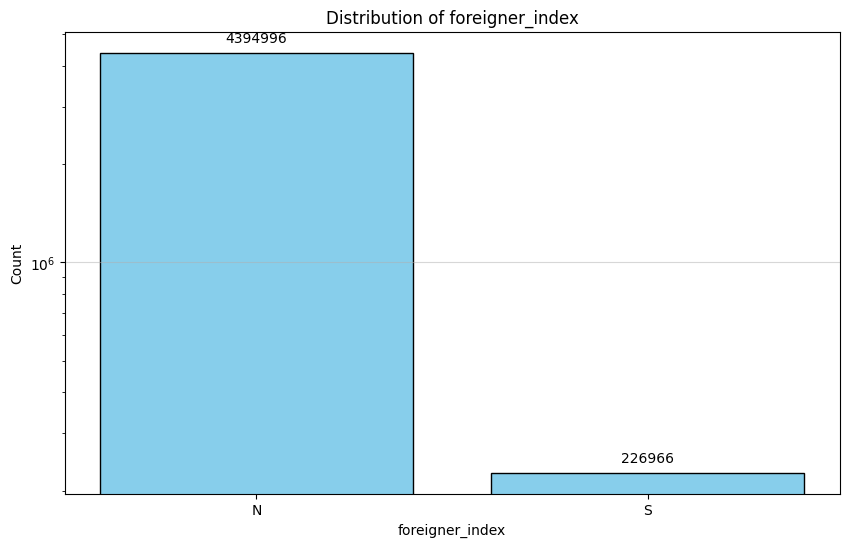

In [ ]:
plot_bar_chart(df, 'foreigner_index')

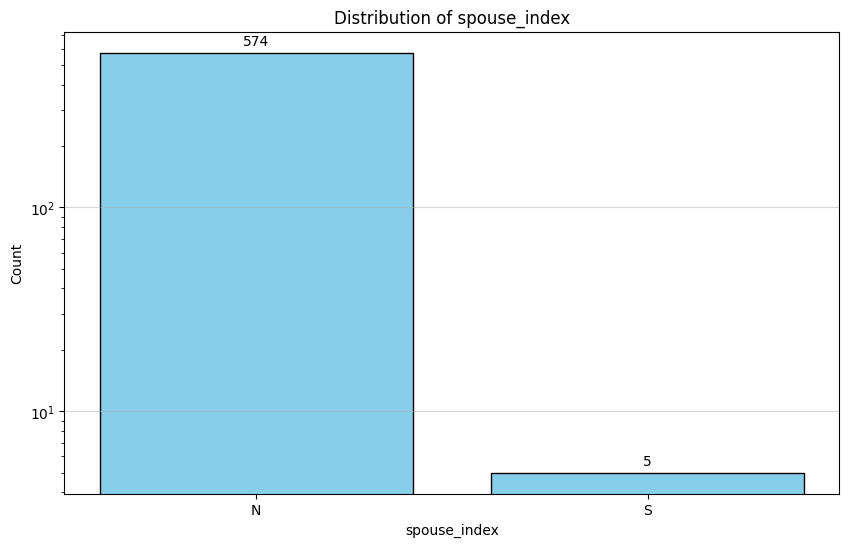

In [ ]:
plot_bar_chart(df, 'spouse_index')

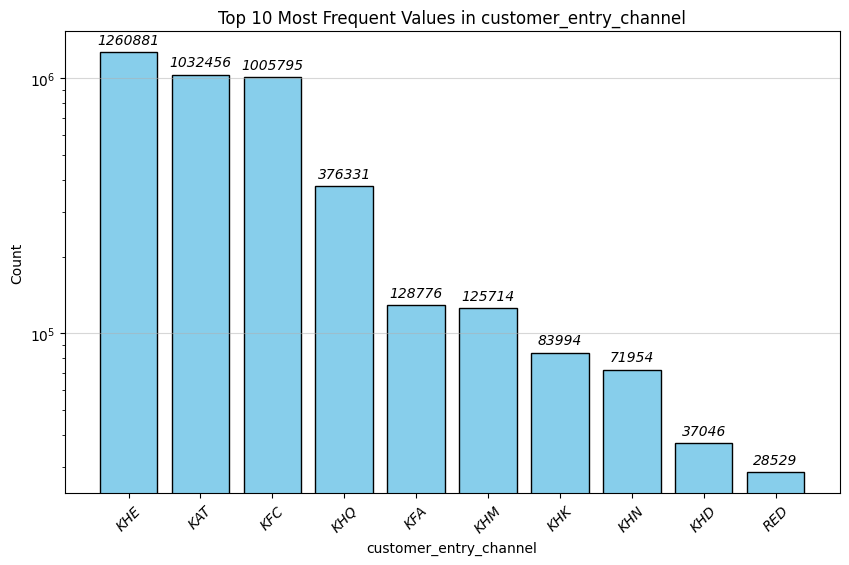

In [ ]:
plot_top_histogram(df, 'customer_entry_channel')

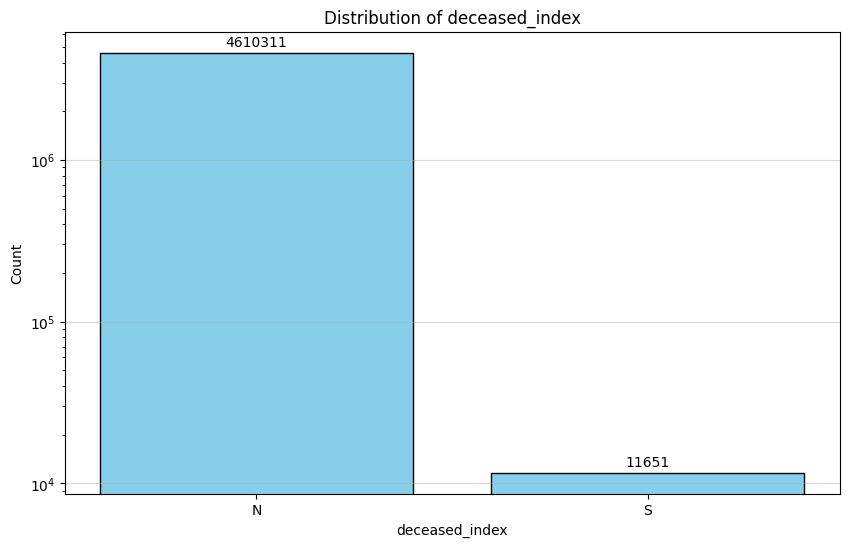

In [ ]:
plot_bar_chart(df, 'deceased_index')

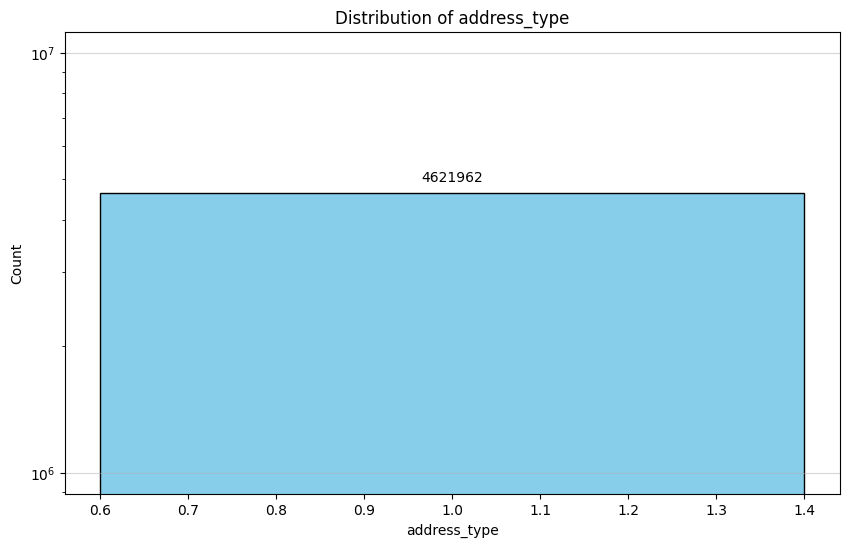

In [ ]:
plot_bar_chart(df, 'address_type')

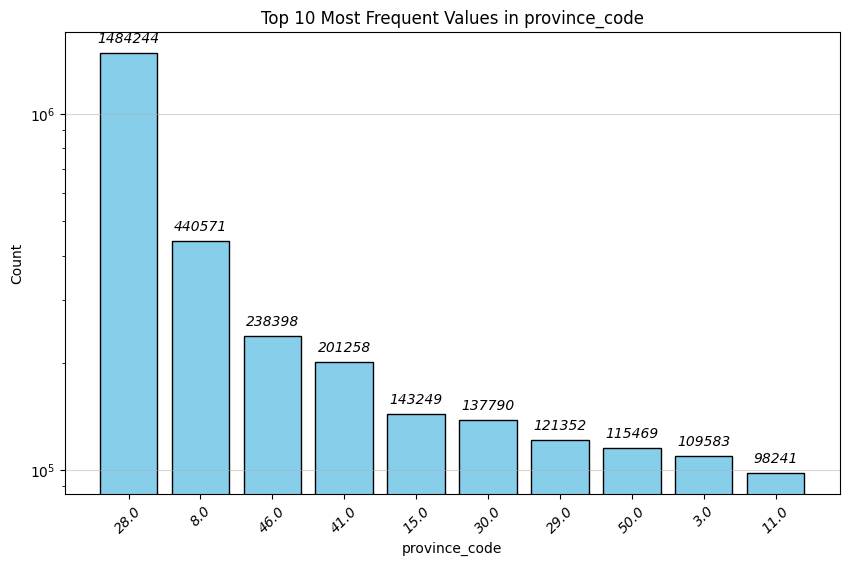

In [ ]:
df.province_code = df.province_code.astype(str)
plot_top_histogram(df, 'province_code')

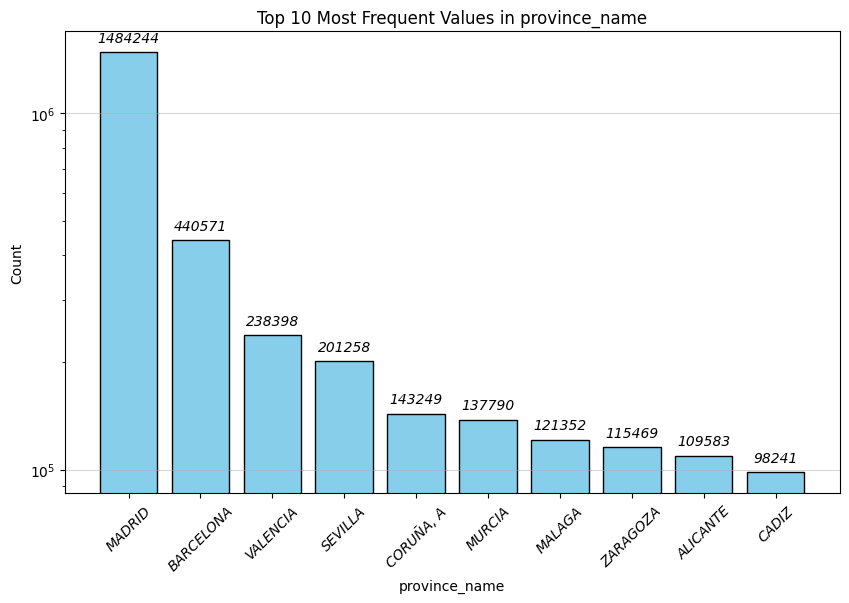

In [ ]:
plot_top_histogram(df, 'province_name')

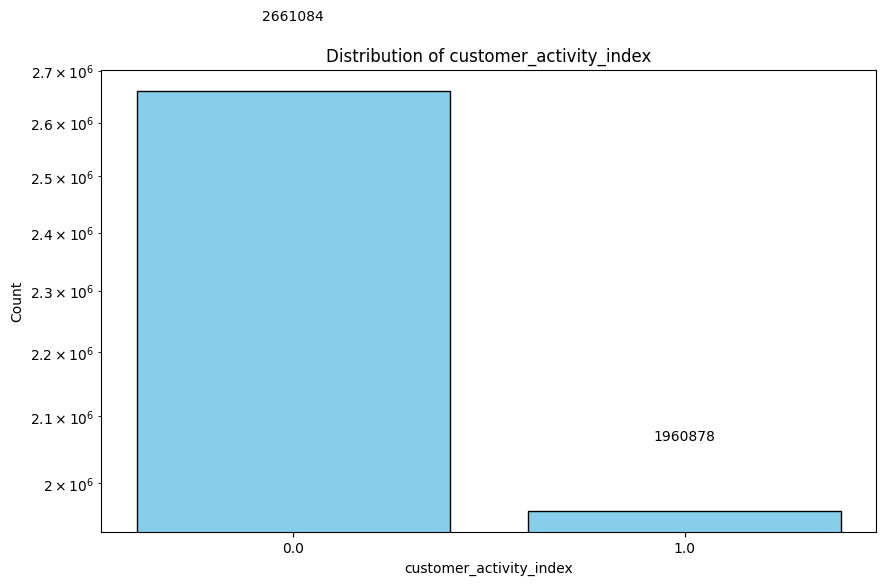

In [ ]:
df.customer_activity_index = df.customer_activity_index.astype(str)
plot_bar_chart(df, 'customer_activity_index')

In [ ]:
df = df[df['household_income'] < df['household_income'].quantile(0.99)]

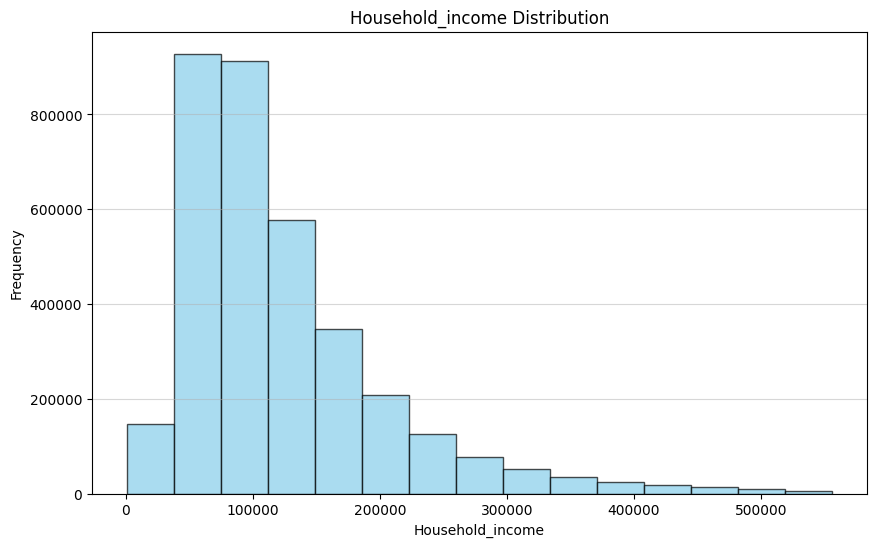

In [ ]:
plot_distribution(df, 'household_income', bins = 15)

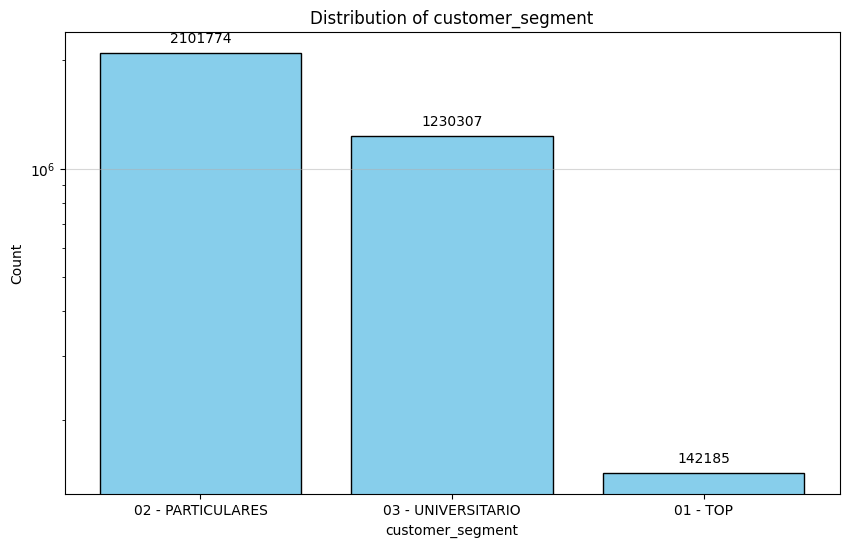

In [ ]:
plot_bar_chart(df, 'customer_segment')

##Phân bố sản phẩm

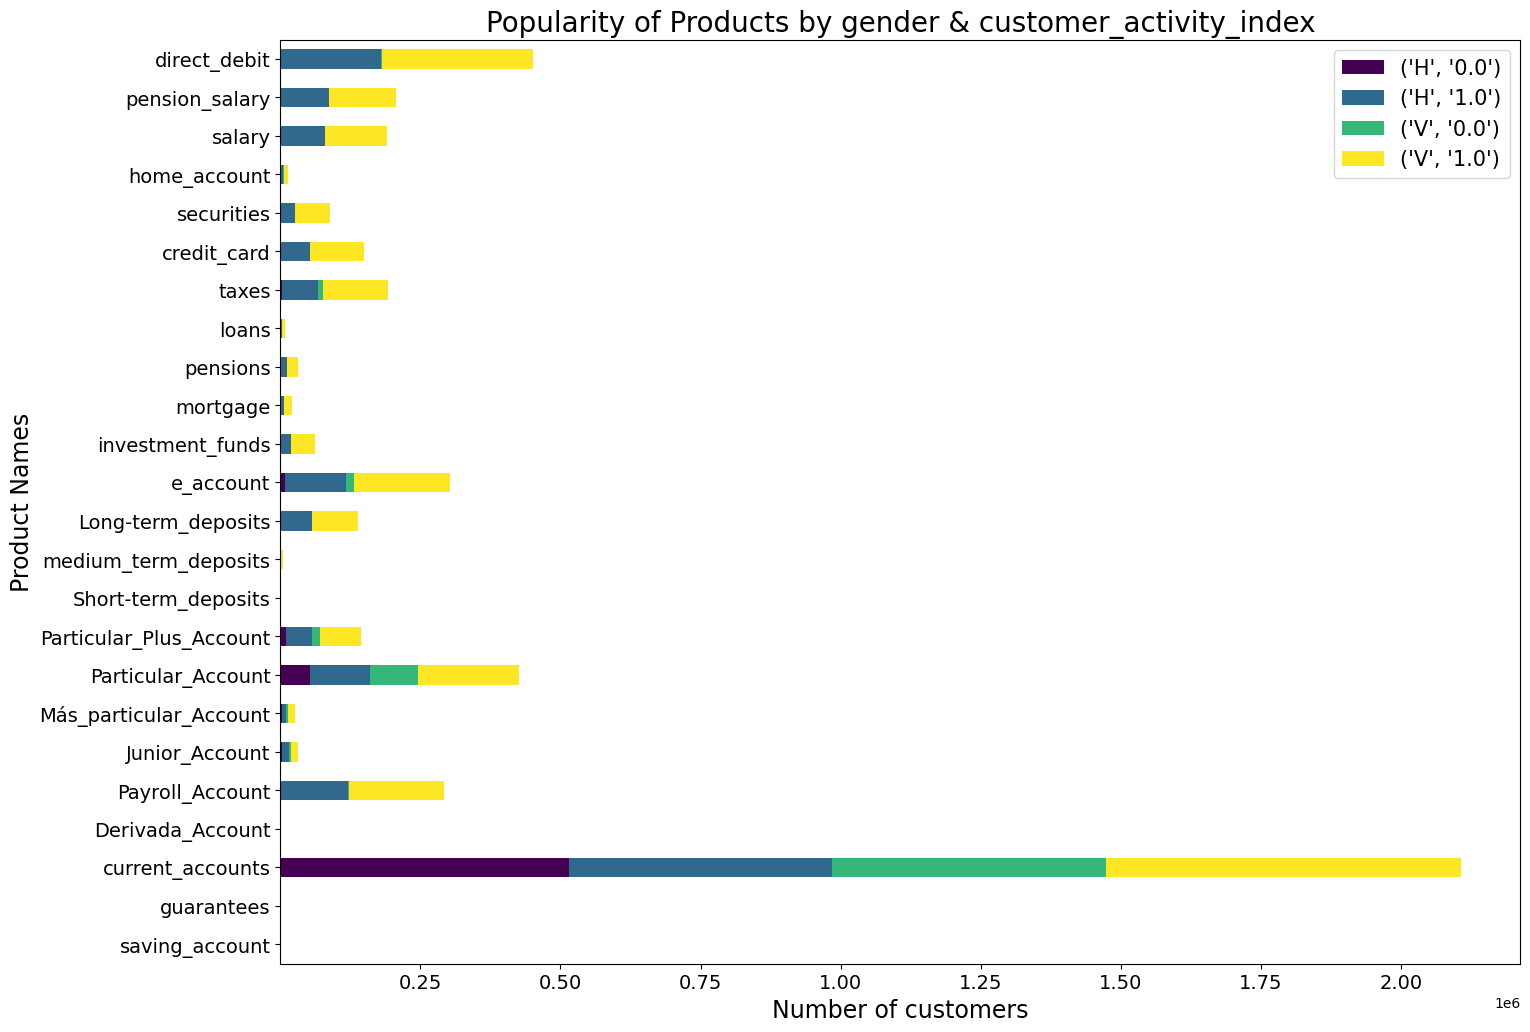

In [ ]:
dis1 = prepare_dataframe(df, 'gender', 'customer_activity_index', 'saving_account', 'direct_debit')
plot_stacked_barh2(dis1, 'gender', 'customer_activity_index')

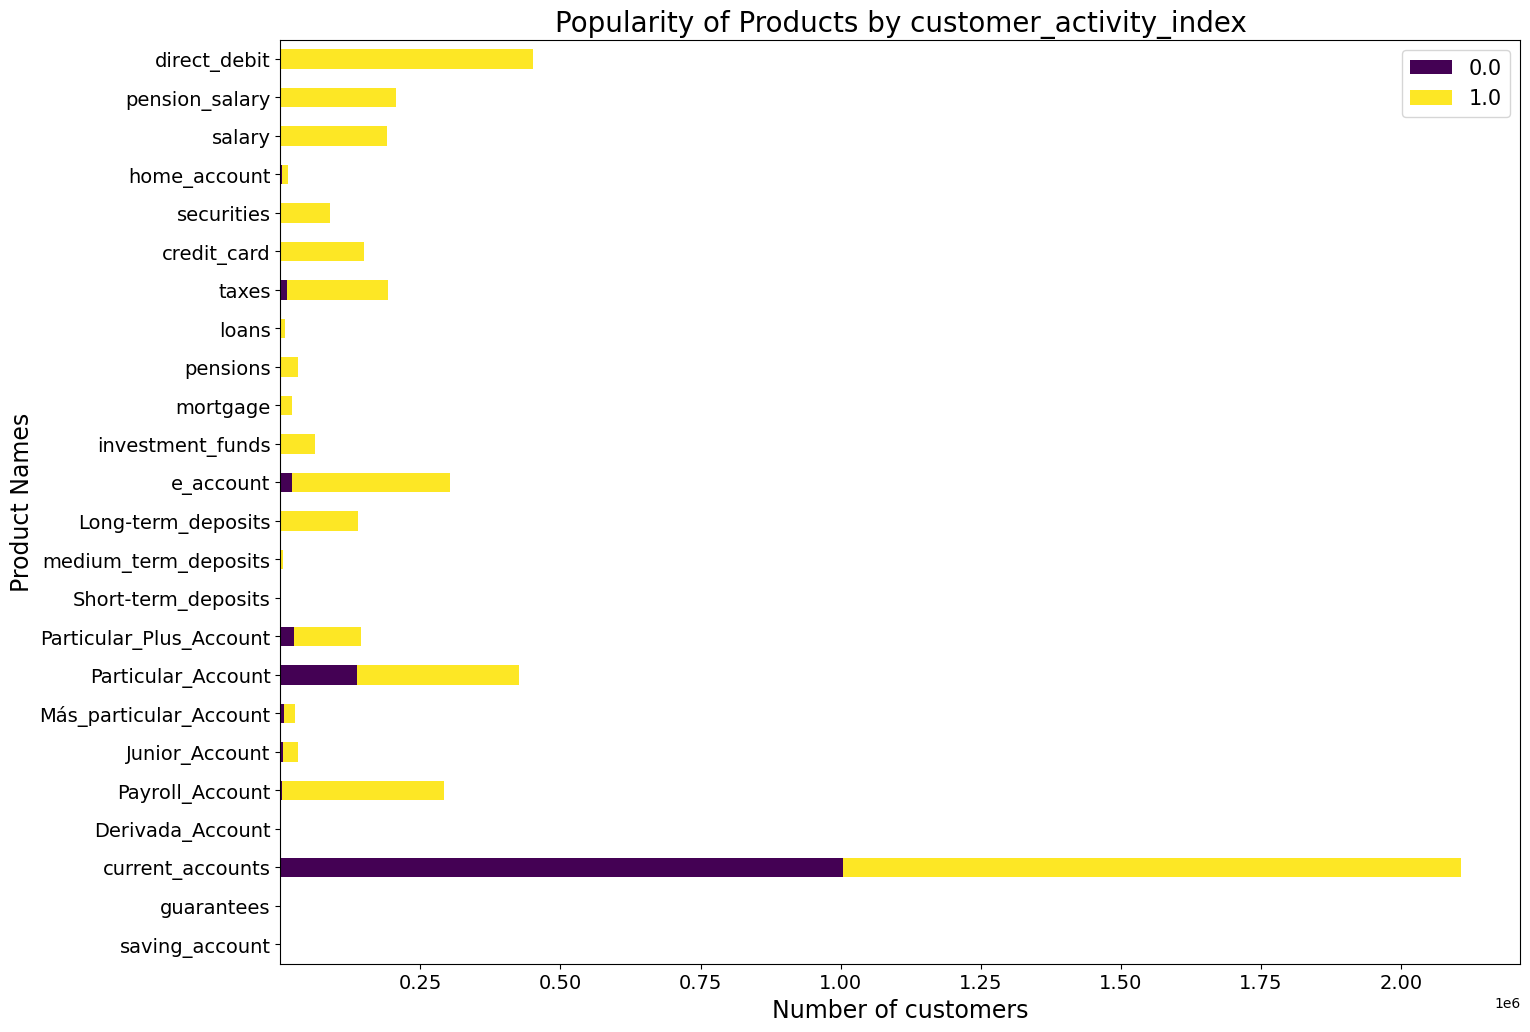

In [ ]:
dis2 = prepare_dataframe2(df, 'customer_activity_index', 'saving_account', 'direct_debit')
plot_stacked_barh(dis2, 'customer_activity_index')

         household_income     income_bin
0                34745.28        0-50000
1               184449.27  100000-200000
2                67044.99   50000-100000
3                42478.02        0-50000
4                89482.35   50000-100000
...                   ...            ...
4331796         161524.86  100000-200000
4344634          98230.47   50000-100000
4515463          41575.89        0-50000
4560015          79635.63   50000-100000
4582141         114175.89  100000-200000

[513443 rows x 2 columns]


<ipython-input-18-5cac8127e23b>:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby('income_bin')[sum_cols].sum().reset_index()


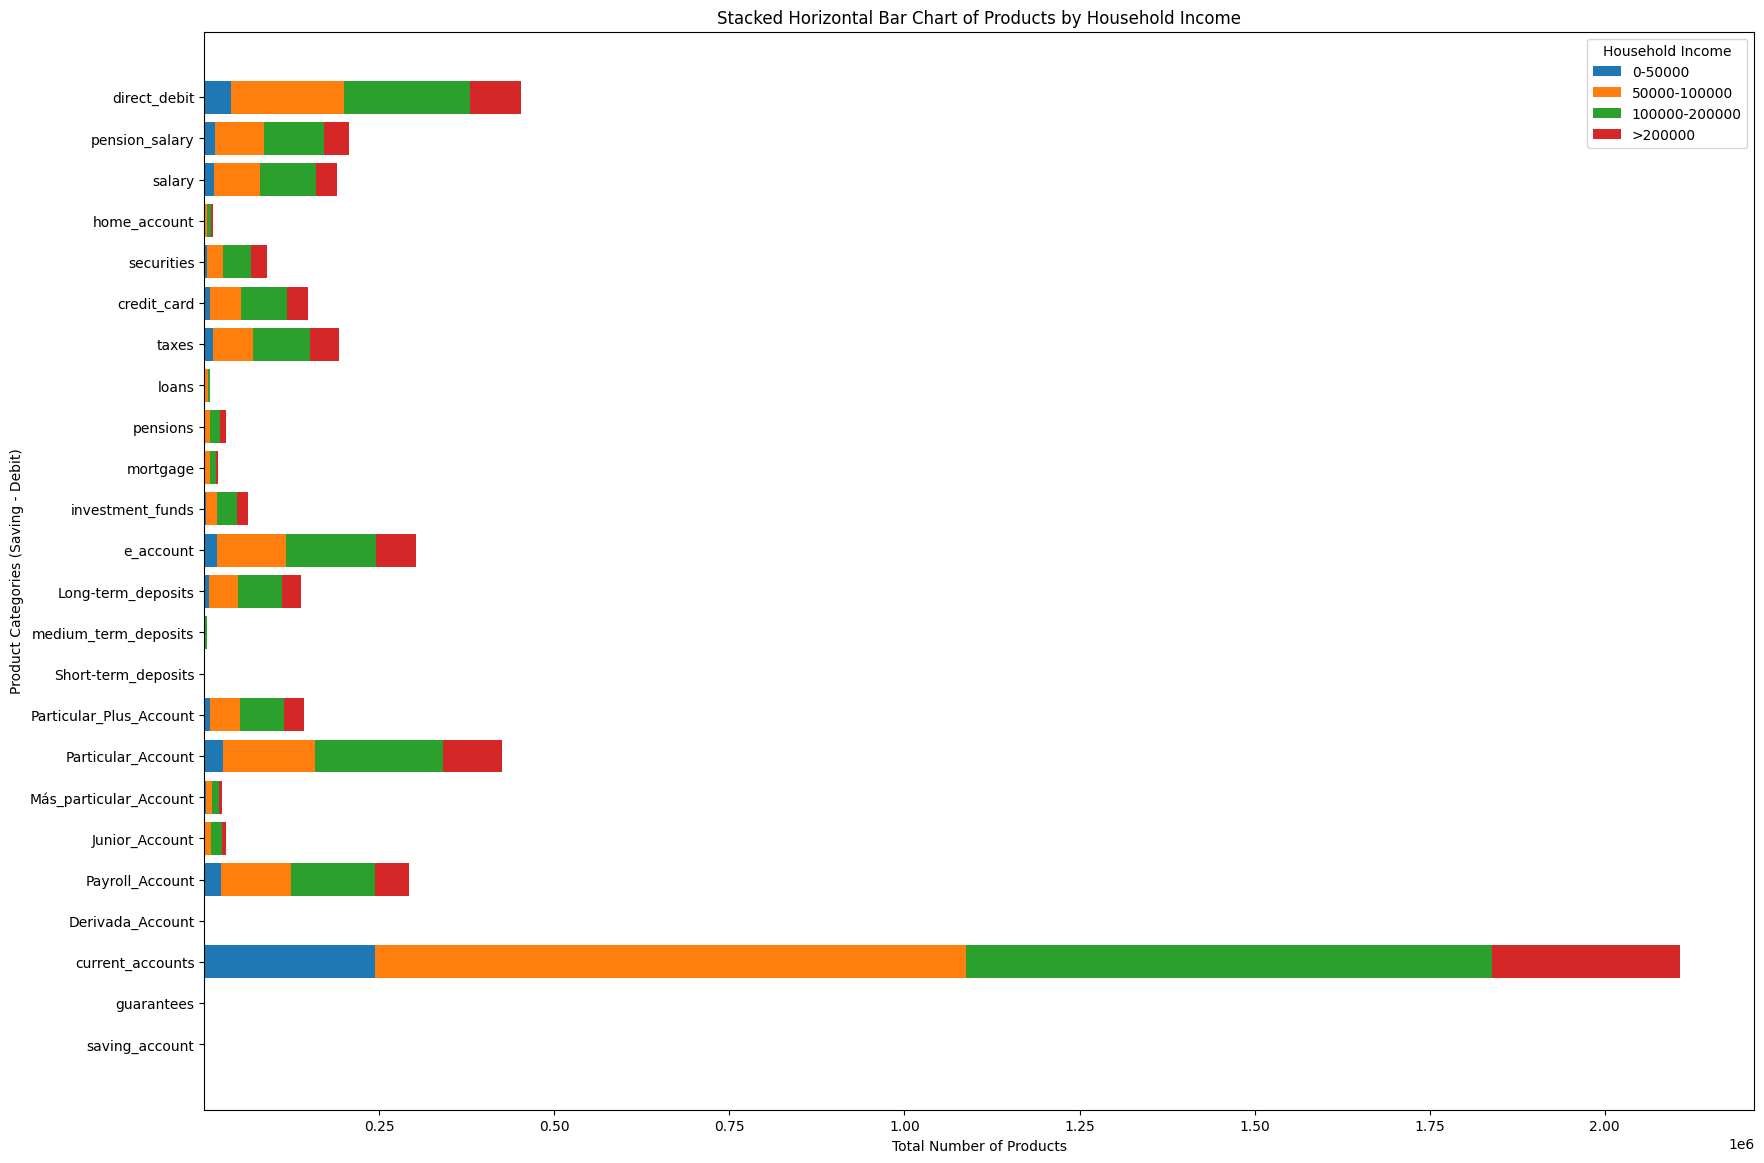

In [ ]:
bins = [0, 50000, 100000, 200000, float('inf')]
labels = ['0-50000', '50000-100000', '100000-200000', '>200000']
df2 = group_and_sum(df, 'household_income', 'saving_account', 'direct_debit', bins, labels)
# Lấy danh sách các cột từ saving_account đến direct_debit
product_columns = df2.columns[1:]

# Vẽ biểu đồ cột ngang chồng với legend ở góc phải trên
fig, ax = plt.subplots(figsize=(20, 14))

# Biến bottom để theo dõi vị trí cột khi xếp chồng
bottom = [0] * len(product_columns)

for index, row in df2.iterrows():
    ax.barh(product_columns, row[1:], label=row["income_bin"], left=bottom)
    bottom = [b + v for b, v in zip(bottom, row[1:])]

# Cấu hình biểu đồ
ax.set_ylabel("Product Categories (Saving - Debit)")
ax.set_xlabel("Total Number of Products")
ax.set_title("Stacked Horizontal Bar Chart of Products by Household Income")

# Đặt legend lên góc phải trên
ax.legend(title="Household Income", loc="upper right", bbox_to_anchor=(1, 1))

# Hiển thị biểu đồ
plt.show()


         household_income income_bin
0                34745.28      20-40
1               184449.27      20-40
2                67044.99      20-40
3                42478.02      20-40
4                89482.35      20-40
...                   ...        ...
4616279         127681.74      40-60
4620317          35824.32      40-60
4620780          45672.99      40-60
4621217          75418.50      40-60
4621745          63197.22      40-60

[576235 rows x 2 columns]


<ipython-input-18-5cac8127e23b>:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby('income_bin')[sum_cols].sum().reset_index()


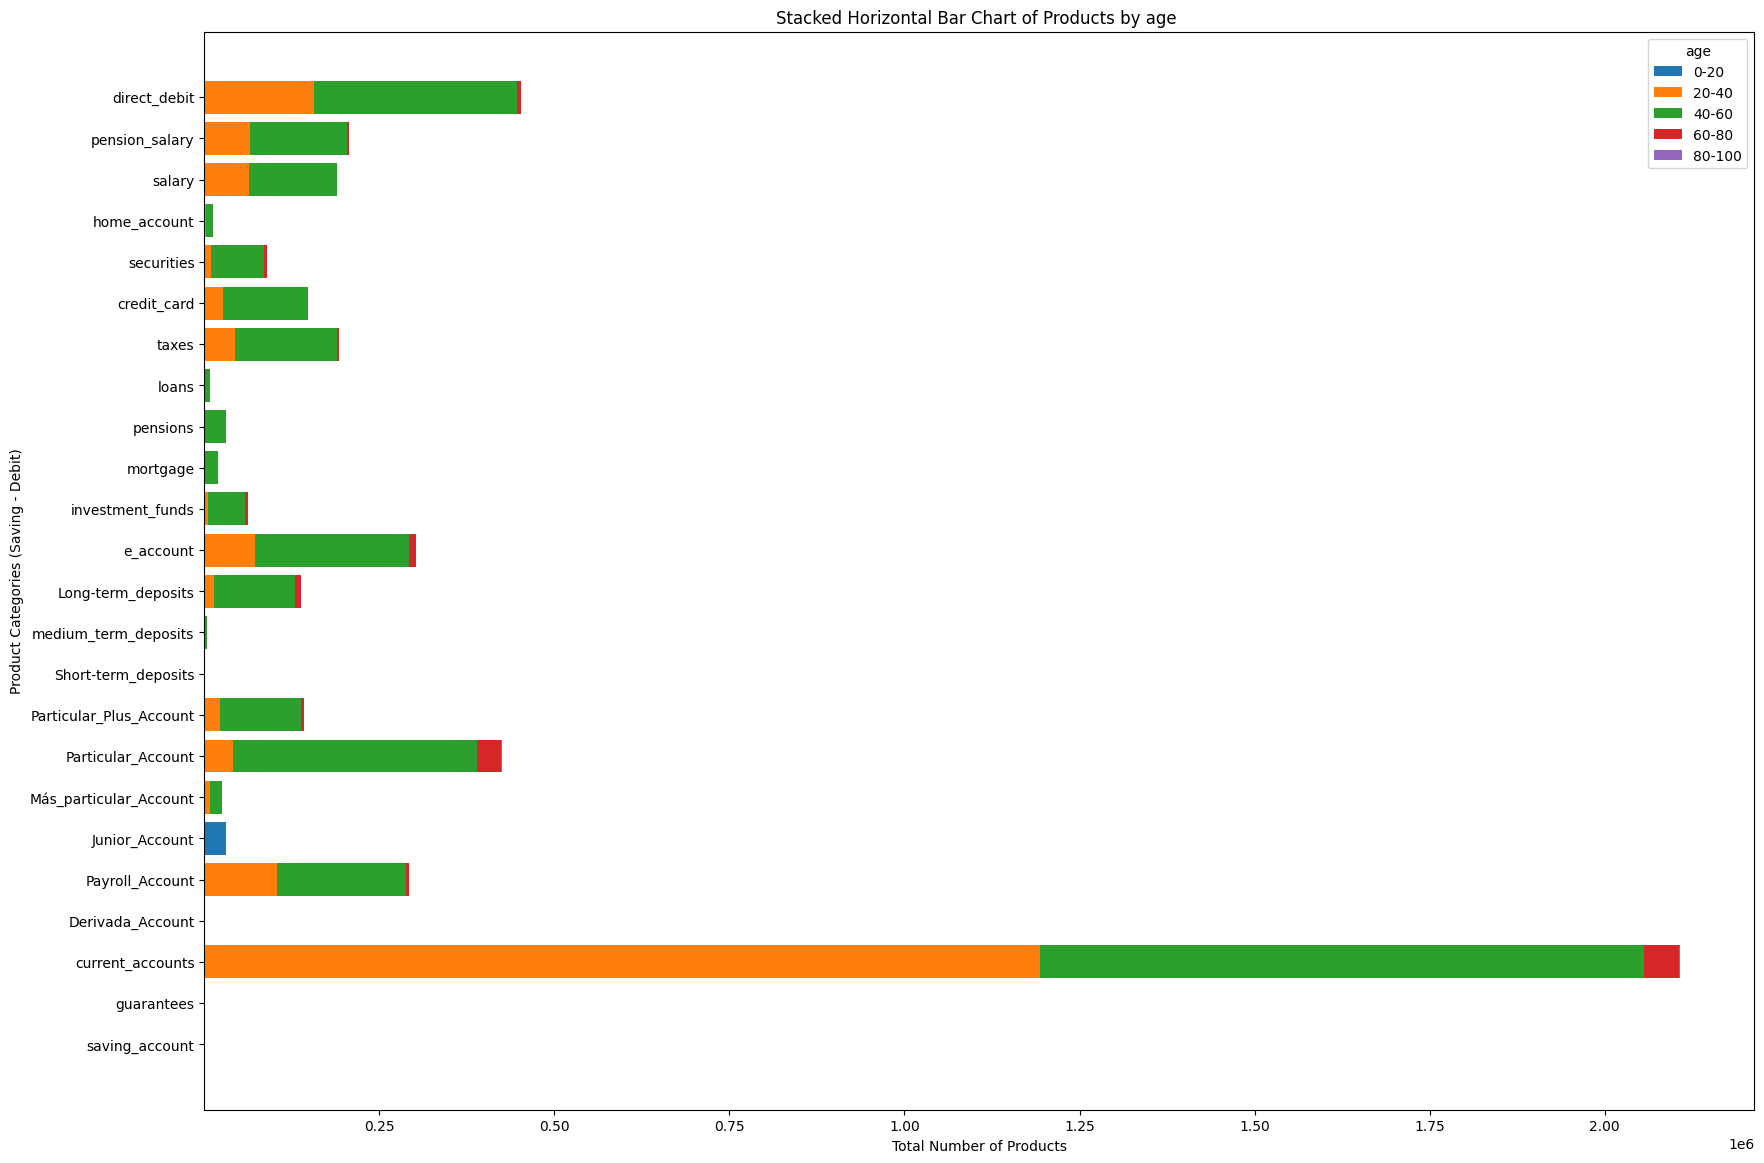

In [ ]:
bins = [0, 20, 40, 80, 100, float('inf')]
labels = ['0-20', '20-40', '40-60', '60-80', '80-100']
df2 = group_and_sum(df, 'Age', 'saving_account', 'direct_debit', bins, labels)
# Lấy danh sách các cột từ saving_account đến direct_debit
product_columns = df2.columns[1:]

# Vẽ biểu đồ cột ngang chồng với legend ở góc phải trên
fig, ax = plt.subplots(figsize=(20, 14))

# Biến bottom để theo dõi vị trí cột khi xếp chồng
bottom = [0] * len(product_columns)

for index, row in df2.iterrows():
    ax.barh(product_columns, row[1:], label=row["income_bin"], left=bottom)
    bottom = [b + v for b, v in zip(bottom, row[1:])]

# Cấu hình biểu đồ
ax.set_ylabel("Product Categories (Saving - Debit)")
ax.set_xlabel("Total Number of Products")
ax.set_title("Stacked Horizontal Bar Chart of Products by age ")

# Đặt legend lên góc phải trên
ax.legend(title="age", loc="upper right", bbox_to_anchor=(1, 1))

# Hiển thị biểu đồ
plt.show()

In [ ]:
df_cus_sen_group = groupby2(df, 'customer_seniority', 'Total', 'mean')

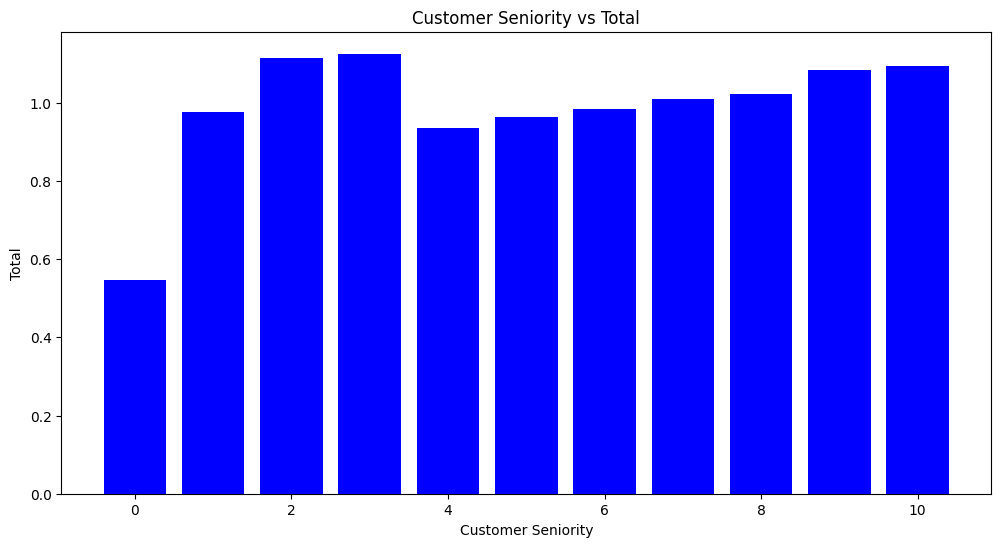

In [ ]:
df_cus_sen_group = df_cus_sen_group[(df_cus_sen_group['customer_seniority'] >= 0) & (df_cus_sen_group['customer_seniority'] <= 10)]
df_cus_sen_group = df_cus_sen_group.sort_values(by='customer_seniority')

plt.figure(figsize=(12, 6))
plt.bar(df_cus_sen_group['customer_seniority'], df_cus_sen_group['Total'], color='blue')
plt.xlabel('Customer Seniority')
plt.ylabel('Total')
plt.title('Customer Seniority vs Total')
plt.show()


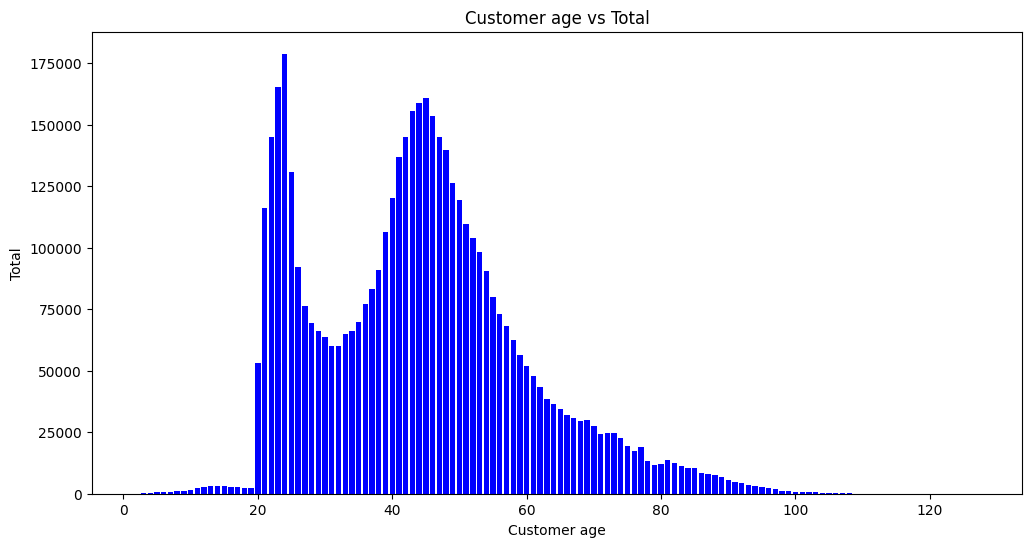

In [ ]:
df_age_group = groupby2(df, 'Age', 'Total', 'sum')

plt.figure(figsize=(12, 6))
plt.bar(df_age_group['Age'], df_age_group['Total'], color='blue')
plt.xlabel('Customer age')
plt.ylabel('Total')
plt.title('Customer age vs Total')
plt.show()

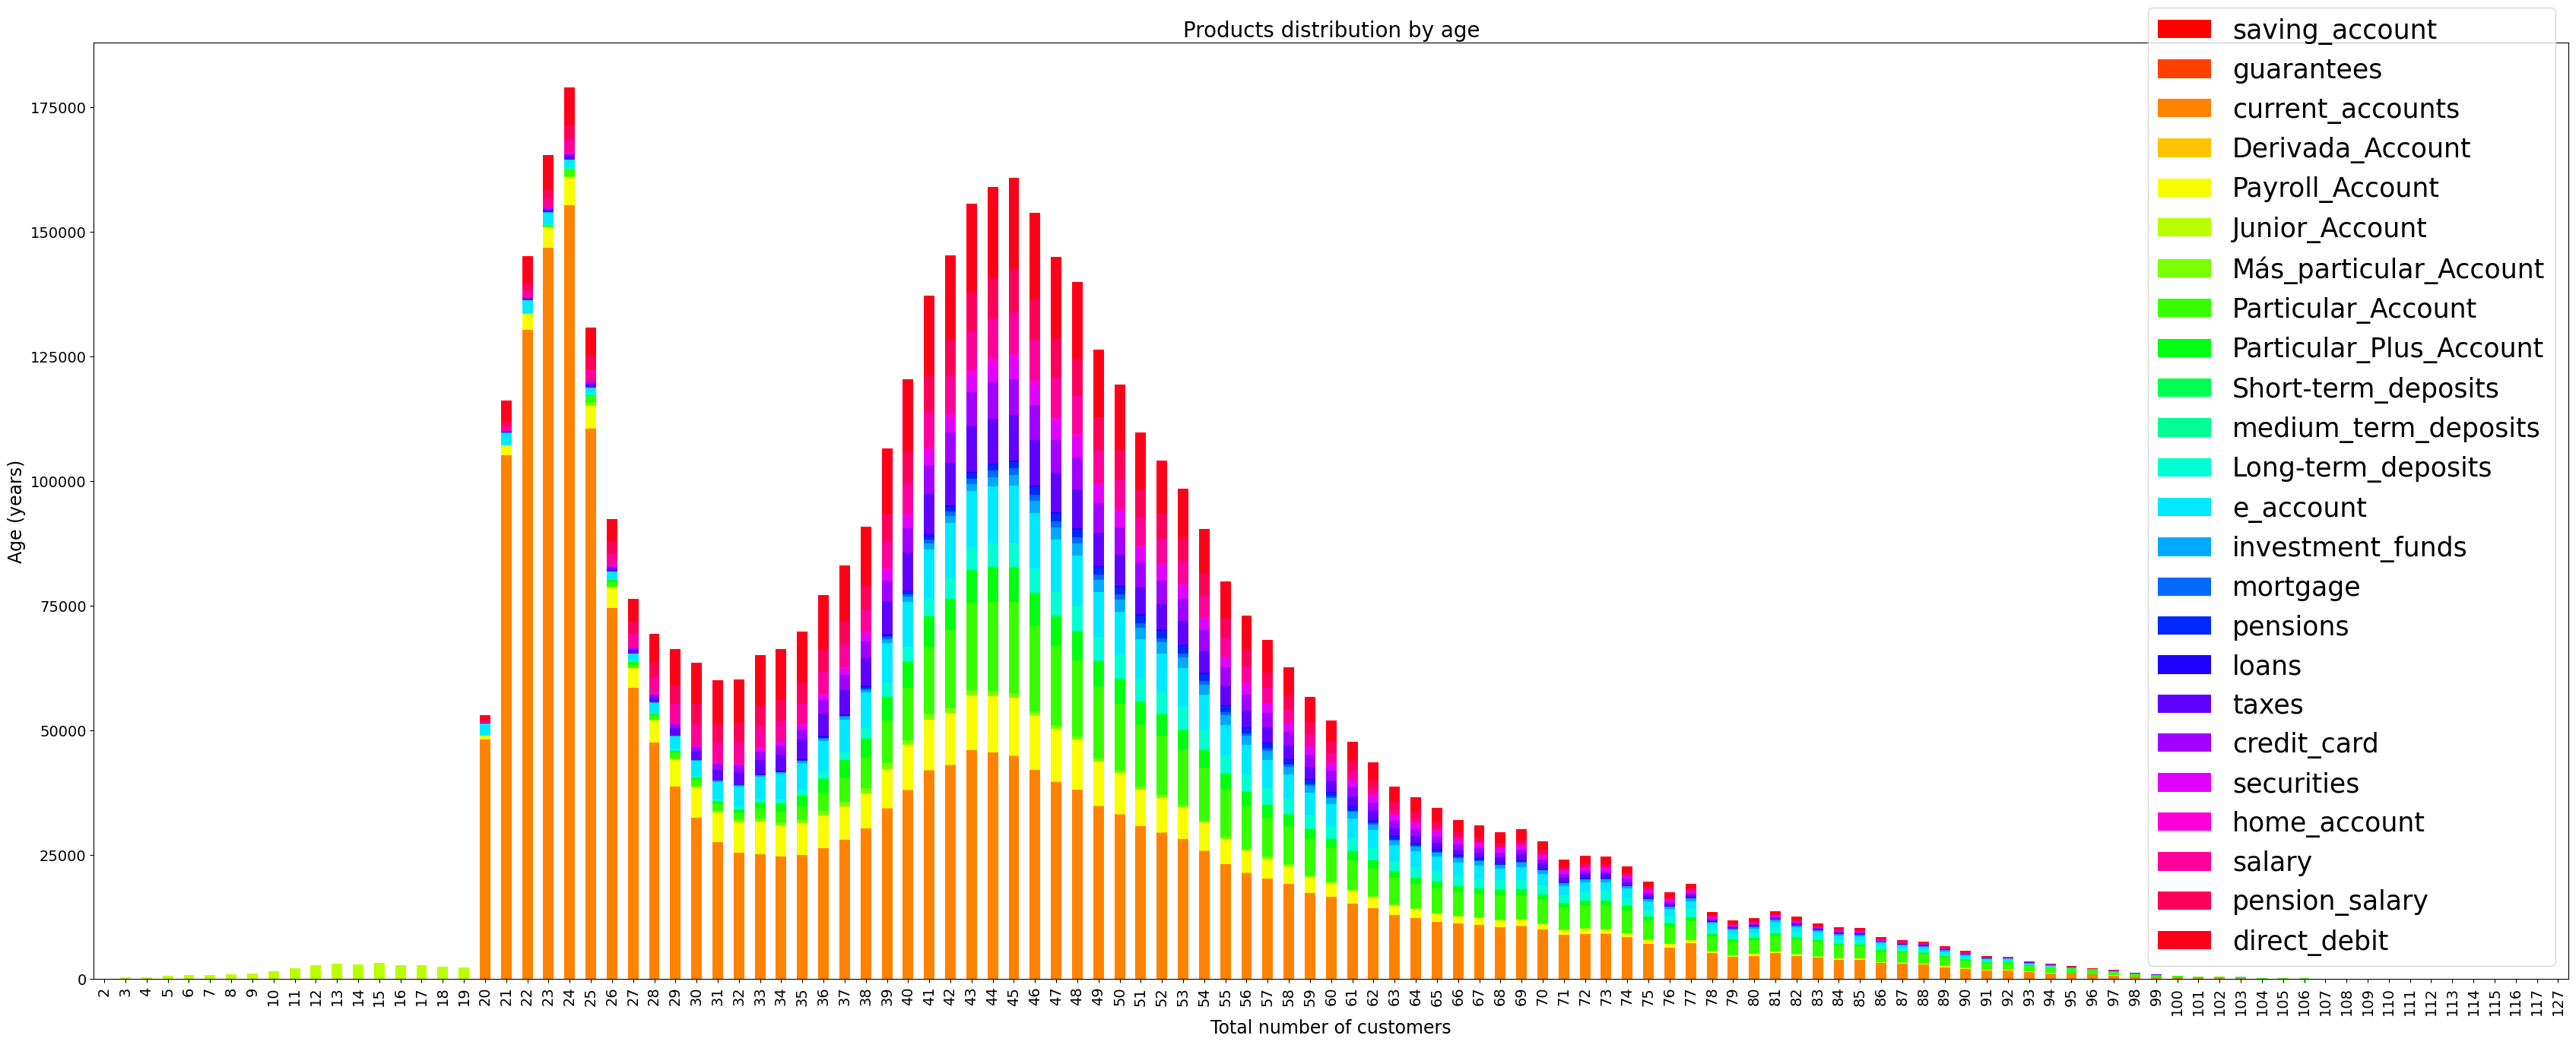

In [ ]:
import matplotlib.pyplot as plt

# Chọn cột "age" và ghép với các cột từ 'saving_account' đến 'direct_debit'
df_a = df.loc[:, ["Age"]].join(df.loc[:, 'saving_account':'direct_debit'])

# Tạo dictionary chứa các phép tính
fnc = {c: 'sum' for c in df_a.columns.drop(['Age']).tolist()}
fnc['Age'] = 'mean'

# Nhóm theo 'age' và thực hiện phép tính
df_a = df_a.groupby('Age').agg(fnc)

# Sắp xếp lại thứ tự các cột (loại bỏ 'age')
df_a = df_a.reindex(columns=df_a.columns.drop('Age'))

# Vẽ biểu đồ
df_a.plot(kind='bar', stacked=True, fontsize=14, figsize=[42, 16], colormap='hsv')
plt.title('Products distribution by age', fontsize=20, color='black')
plt.xlabel('Total number of customers', fontsize=17, color='black')
plt.ylabel('Age (years)', fontsize=17, color='black')
plt.legend(prop={'size': 25})
plt.show()


<ipython-input-54-60642ef67210>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_a = df1.groupby("Age Group").sum(numeric_only=True)


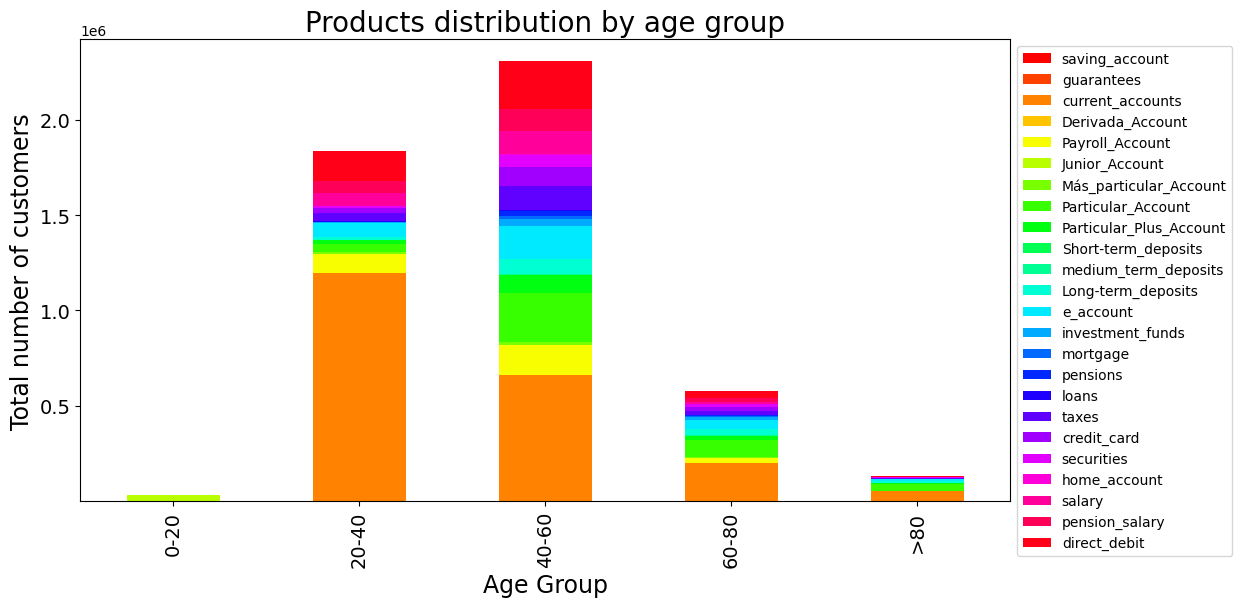

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = df.copy()

bins = [0, 20, 40, 60, 80, float('inf')]
labels = ["0-20", "20-40", "40-60", "60-80", ">80"]
df1["Age Group"] = pd.cut(df1["Age"], bins=bins, labels=labels, right=False)
# Chọn các cột liên quan và nhóm theo nhóm tuổi
df_a = df1.groupby("Age Group").sum(numeric_only=True)

df = df1.copy()
# Lọc danh sách các cột cần hiển thị trong legend
df_a_filtered = df_a.loc[:, "saving_account":"direct_debit"]

# Vẽ biểu đồ với các cột đã chọn
ax = df_a_filtered.plot(kind='bar', stacked=True, fontsize=14, figsize=[12, 6], colormap='hsv')
plt.title('Products distribution by age group', fontsize=20, color='black')
plt.xlabel('Age Group', fontsize=17, color='black', rotation = 'horizontal')
plt.ylabel('Total number of customers', fontsize=17, color='black')

# Đưa legend ra bên phải với chỉ các cột mong muốn
plt.legend(prop={'size': 10}, loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


<ipython-input-55-4c0ad6bd51c4>:7: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  df_a = df_b["customer_seniority"][0:10]


Text(0, 0.5, 'Average seniority')

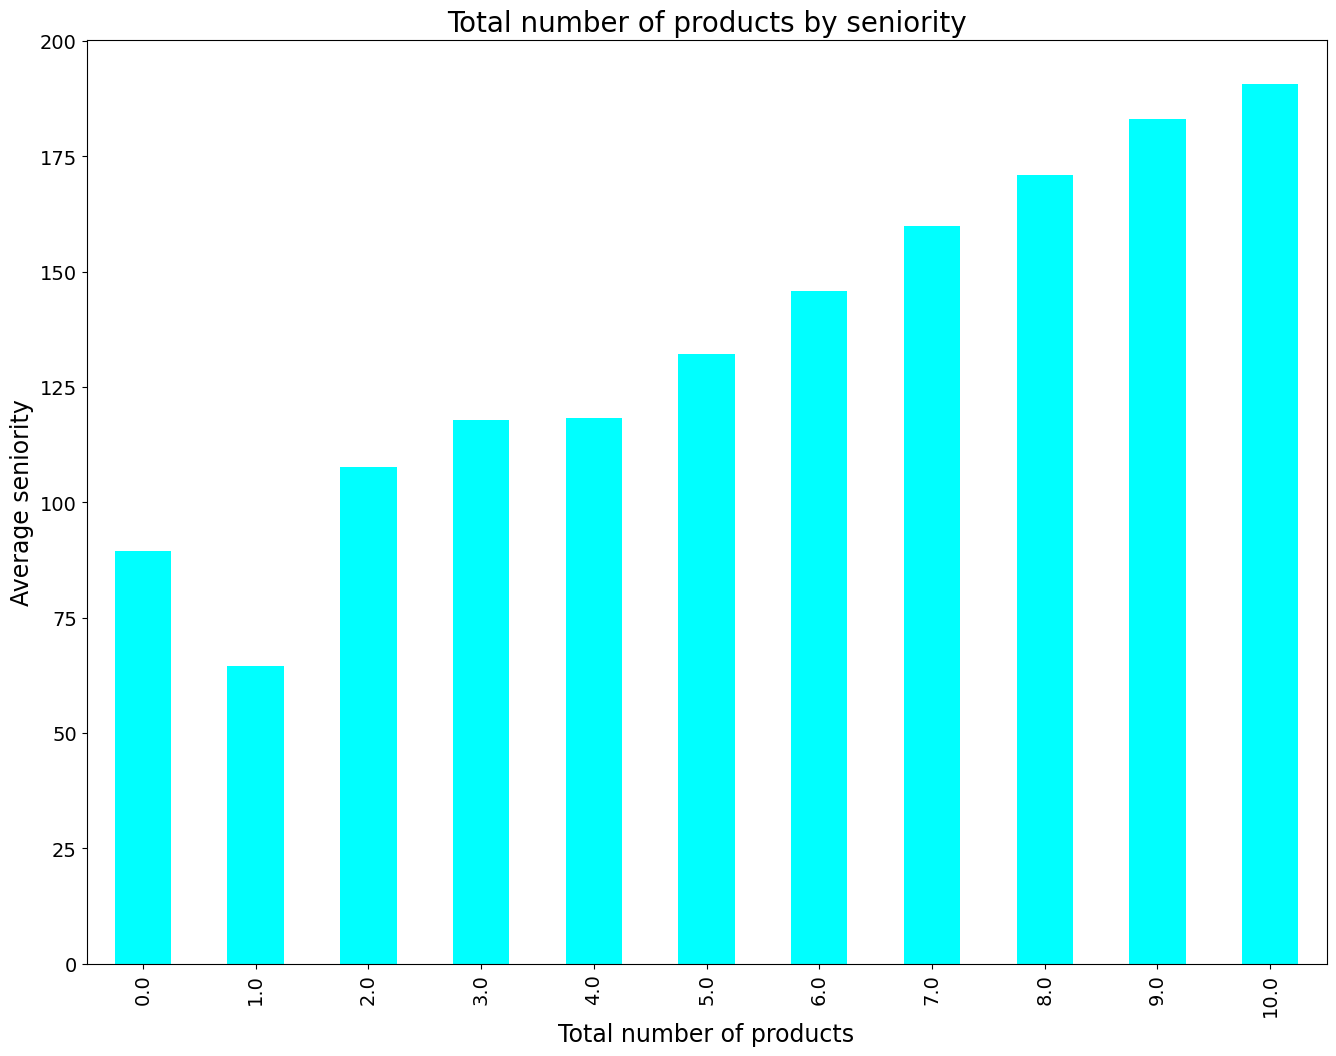

In [ ]:
df = df[df['customer_seniority'] >= 0]
df_a = df.loc[:, ['Age', 'household_income', 'customer_seniority']].join(df.loc[:, 'saving_account':'Total'])
df_a = df_a.dropna(axis=0)
df_a = df_a.groupby("Total").agg("mean")
df_b = df_a.loc[:, ['Age', 'household_income', 'customer_seniority']]
df_b.head()
df_a = df_b["customer_seniority"][0:10]
# Total number of products by seniority
df_a.plot(kind='bar', fontsize=14, figsize=[16,12], colormap='cool')
plt.title('Total number of products by seniority', fontsize=20, color='black')
plt.xlabel('Total number of products', fontsize=17, color='black')
plt.ylabel('Average seniority', fontsize=17, color='black')
#plt.legend(prop={'size':15})

In [ ]:
df.head()

,date,customer_code,employee_index,country_residence,gender,Age,date_joined,new_customer_index,customer_seniority,customer_type,...,securities,home_account,salary,pension_salary,direct_debit,Total,year_joined,month_joined,income_bin,Age Group
0,2016-01-28,1432296,N,ES,V,20,2015-08-07,1.0,5,1.0,...,0,0,0.0,0.0,0,1.0,2015,8,20-40,20-40
1,2016-01-28,1432294,N,ES,H,25,2015-08-07,1.0,5,1.0,...,0,0,0.0,0.0,0,1.0,2015,8,20-40,20-40
2,2016-01-28,1432293,N,ES,H,20,2015-08-07,1.0,5,1.0,...,0,0,0.0,0.0,0,0.0,2015,8,20-40,20-40
3,2016-01-28,1432292,N,ES,V,23,2015-08-07,1.0,5,1.0,...,0,0,0.0,0.0,0,1.0,2015,8,20-40,20-40
4,2016-01-28,1432297,N,ES,H,20,2015-08-07,1.0,5,1.0,...,0,0,0.0,0.0,0,1.0,2015,8,20-40,20-40


In [ ]:
# Tính toán trước giá trị để không phải gọi lại max() nhiều lần
y_min = df["Total"].iloc[0] - 5000
y_max = df["Total"].max() + 10000

# Chuyển đổi cột "date" thành dạng datetime với đúng format
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d", errors="coerce")

# Trích xuất tháng và năm để nhóm dữ liệu
df["Month"] = df["date"].dt.strftime("%Y-%m")  # Định dạng YYYY-MM để nhóm theo tháng

# Tính tổng sản phẩm theo từng tháng
df_monthly = df.groupby("Month")["Total"].sum().reset_index()
df_monthly["Monthly Increase"] = df_monthly["Total"].diff().fillna(0)

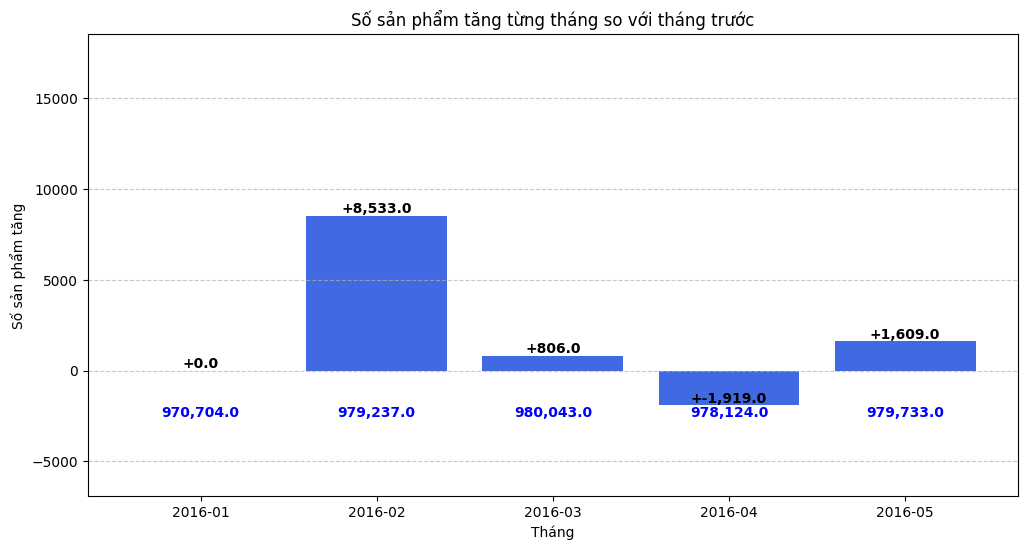

In [ ]:
# Tạo biểu đồ tối ưu với tổng sản phẩm hiển thị ở chân mỗi tháng
fig, ax = plt.subplots(figsize=(12, 6))

# Tính trước y_min và y_max để tối ưu hiệu suất
y_min = df_monthly["Monthly Increase"].min() - 5000
y_max = df_monthly["Monthly Increase"].max() + 10000

ax.set_ylim(y_min, y_max)

bars = ax.bar(df_monthly["Month"], df_monthly["Monthly Increase"], color='royalblue')

# Ghi chú số tăng thêm trên từng cột
for i in range(len(bars)):
    ax.text(bars[i].get_x() + bars[i].get_width()/2, bars[i].get_height(), f"+{df_monthly['Monthly Increase'].iloc[i]:,}",
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Hiển thị tổng sản phẩm ở chân mỗi tháng
for i in range(len(bars)):
    ax.text(bars[i].get_x() + bars[i].get_width()/2, y_min + 5000, f"{df_monthly['Total'].iloc[i]:,}",
            ha='center', va='top', fontsize=10, fontweight='bold', color='blue')

# Giảm số lượng nhãn trên trục X nếu có quá nhiều tháng
if len(df_monthly) > 12:
    step = len(df_monthly) // 12  # Hiển thị khoảng 12 tháng trên trục X
    ax.set_xticks(df_monthly["Month"][::step])
    ax.set_xticklabels(df_monthly["Month"][::step], rotation=45)

# Thiết lập tiêu đề và nhãn trục
ax.set_title("Số sản phẩm tăng từng tháng so với tháng trước")
ax.set_xlabel("Tháng")
ax.set_ylabel("Số sản phẩm tăng")
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị biểu đồ
plt.show()


##Tương quan

In [ ]:
df = df1.copy()

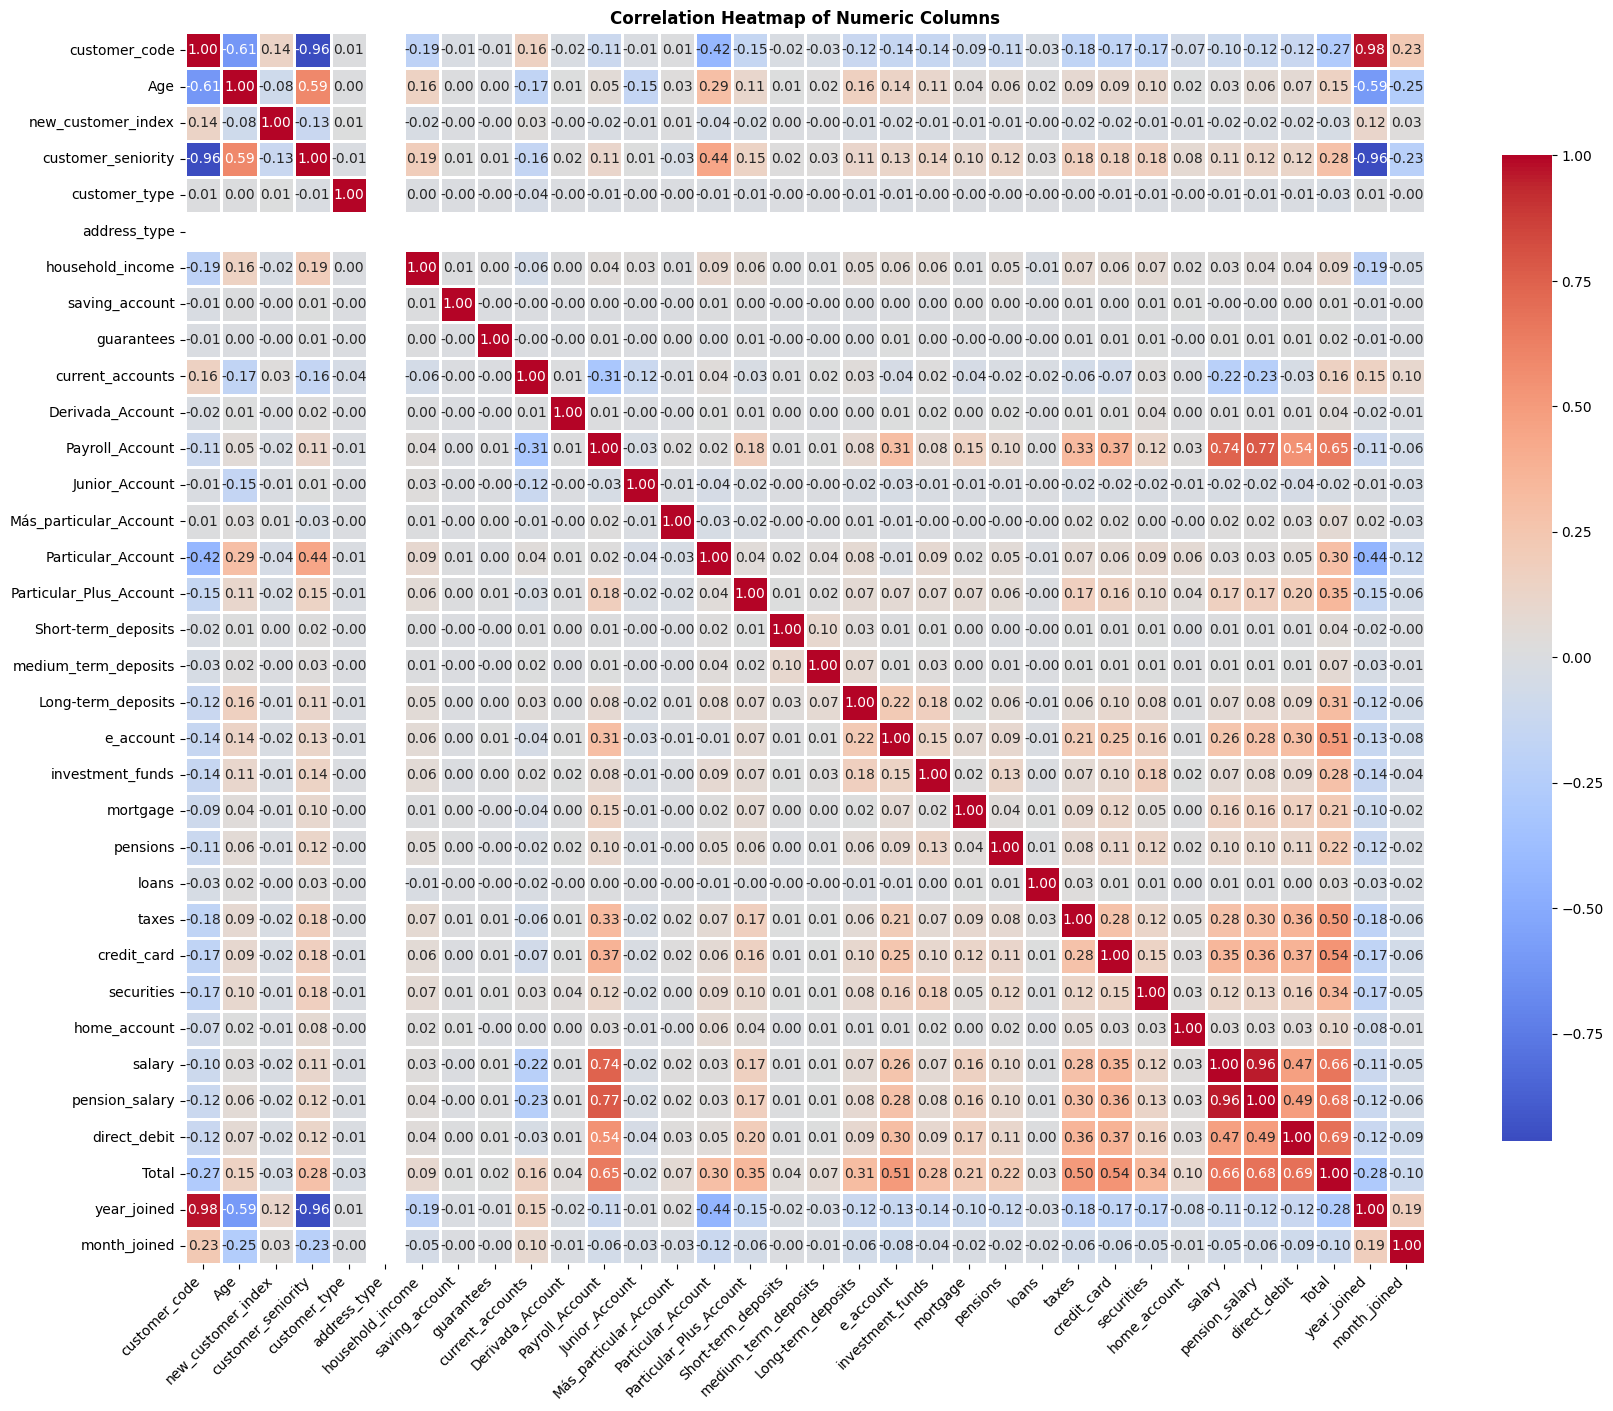

In [ ]:
# Chỉ lấy các cột numeric
df_numeric = df.select_dtypes(include=['number'])

# Tính toán ma trận tương quan
correlation_matrix = df_numeric.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1,
            annot_kws={"size": 10}, cbar_kws={'shrink': .8})
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Correlation Heatmap of Numeric Columns", fontsize=12, fontweight='bold')
plt.show()


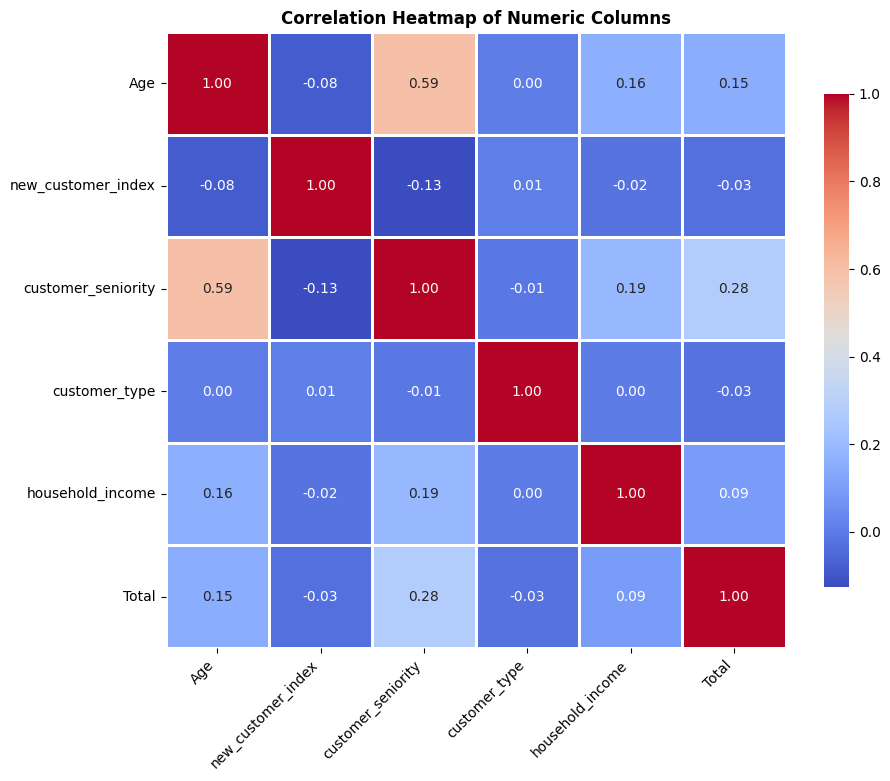

In [ ]:
# Chỉ lấy 24 dòng đầu tiên
df24 = df.iloc[:, :24]  # Lấy 24 cột đầu tiên
df2 = pd.concat([df24, df[['Total']]], axis=1)  # Ghép thêm cột 'Total'


# Chỉ lấy các cột numeric
df_numeric = df2.select_dtypes(include=['number']).drop(columns=['address_type', 'customer_code'], errors='ignore')

# Tính toán ma trận tương quan
correlation_matrix = df_numeric.corr()

# Vẽ biểu đồ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1,
            annot_kws={"size": 10}, cbar_kws={'shrink': .8})
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Correlation Heatmap of Numeric Columns", fontsize=12, fontweight='bold')
plt.show()


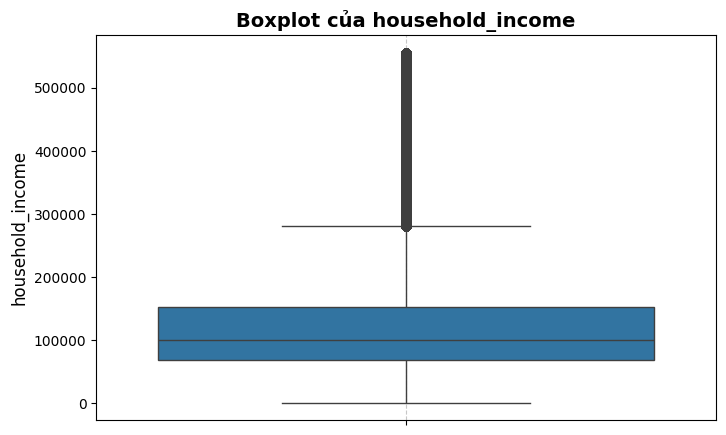

In [ ]:
plot_boxplot(df, 'household_income')

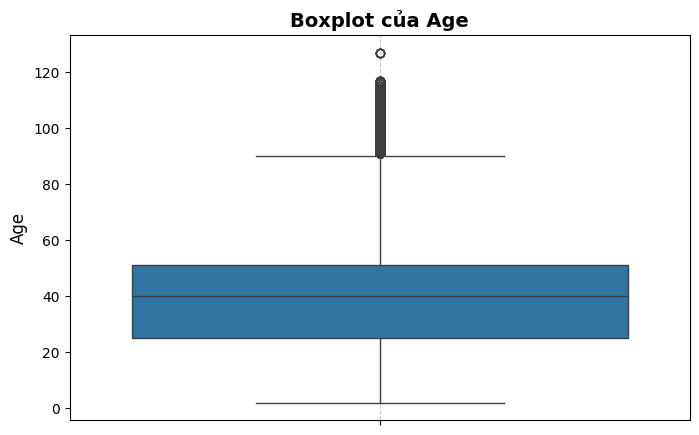

In [ ]:
plot_boxplot(df, 'Age')

# **TIỀN XỬ LÍ DỮ LIỆU**

## Chuẩn bị các tập dữ liệu

### Dữ liệu train và test

In [ ]:
import csv
import pandas as pd

def process_csv(in_file_name):
    """
    Xử lý dữ liệu từ file CSV:
    - Lọc dữ liệu train dựa trên danh sách ngày cụ thể.
    - Lọc dữ liệu actual (tháng 5/2016).
    - Loại bỏ khách hàng mới xuất hiện trong tháng 5 nhưng có antiguedad > 0.
    - Xuất ra file train.csv và test.csv.
    """
    # Danh sách ngày cần lọc cho tập train
    train_dates = ['2015-01-28', '2015-02-28', '2015-03-28', '2015-04-28', '2015-05-28',
                   '2016-01-28', '2016-02-28', '2016-03-28', '2016-04-28']
    actual_date = '2016-05-28'

    # Đọc dữ liệu từ CSV
    data_list = []
    with open(in_file_name, mode='r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            data_list.append(row)

    # Chuyển danh sách thành DataFrame để dễ xử lý
    df = pd.DataFrame(data_list)

    # Chuyển đổi antiguedad về kiểu số để xử lý lọc dữ liệu
    df['antiguedad'] = pd.to_numeric(df['antiguedad'], errors='coerce').fillna(0).astype(int)

    # Lọc dữ liệu train
    train_df = df[df['fecha_dato'].isin(train_dates)]

    # Lọc dữ liệu actual (tháng 5/2016)
    actual_df = df[df['fecha_dato'] == actual_date]

    # Lọc bỏ những khách hàng mới trong tháng 5 nhưng có antiguedad > 0
    # (Chỉ giữ khách hàng đã xuất hiện trước đó hoặc có antiguedad = 0)
    previous_customers = train_df['ncodpers'].unique()
    test_df = actual_df[(actual_df['ncodpers'].isin(previous_customers)) | (actual_df['antiguedad'] == 0)]

    # Bỏ cột sản phẩm trong tập test (chỉ giữ thông tin khách hàng)
    products = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
       'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
       'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
       'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
       'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
       'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
       'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
       'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']

    test_df = test_df.drop(columns=products, errors='ignore')

    # Lưu vào file CSV
    train_df.to_csv("train.csv", index=False, encoding='utf-8')
    test_df.to_csv("test.csv", index=False, encoding='utf-8')

    print(f"✅ Train dataset saved: {train_df.shape[0]} rows")
    print(f"✅ Test dataset saved (filtered): {test_df.shape[0]} rows")


# Chạy hàm với đường dẫn file CSV đầu vào
process_csv('/content/drive/MyDrive/Cuộc thi/Năm 2/Kỳ 2/Data Flow/[Data Flow 2025] Insights Flow /01. Vòng 1/Data/data.csv')


### Dữ liệu thực tế (actual)

In [ ]:
import csv
import pandas as pd

def process_added_products(csv_file_path):
    """
    Xử lý dữ liệu từ file CSV để tìm sản phẩm mới được thêm vào trong tháng 5/2016 so với tháng 4/2016.
    Đọc file bằng DictReader để giảm tiêu tốn RAM và loại bỏ khách hàng xuất hiện mới trong tháng 5 nhưng có antiguedad > 0.
    """
    # Các cột cần đọc
    columns = ['fecha_dato', 'ncodpers', 'antiguedad',
               'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
               'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
               'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
               'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
               'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
               'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
               'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
               'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']

    # Khởi tạo dictionary để lưu dữ liệu
    april_data = {}
    may_data = {}

    # Đọc file CSV bằng DictReader để tiết kiệm RAM
    with open(csv_file_path, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            fecha_dato = row['fecha_dato']
            ncodpers = int(row['ncodpers'])
            antiguedad = int(row['antiguedad']) if row['antiguedad'] not in ['', 'NA'] else 0  # Chuyển đổi antiguedad

            # Chỉ lấy dữ liệu tháng 4 và tháng 5 năm 2016
            if fecha_dato not in ['2016-04-28', '2016-05-28']:
                continue

            # Lưu thông tin sản phẩm của khách hàng
            product_data = {col: int(float(row[col])) if row[col] != '' else 0 for col in columns[3:]}

            if fecha_dato == '2016-04-28':
                april_data[ncodpers] = product_data
            elif fecha_dato == '2016-05-28':
                may_data[ncodpers] = {'antiguedad': antiguedad, 'products': product_data}

    # Loại bỏ khách hàng xuất hiện mới trong tháng 5 nhưng có antiguedad > 0
    filtered_may_data = {cust: data['products'] for cust, data in may_data.items() if cust in april_data or data['antiguedad'] == 0}

    # Tìm khách hàng có trong tháng 5 nhưng không có trong tháng 4 và gán giá trị 0 cho tháng 4
    for customer in filtered_may_data.keys():
        if customer not in april_data:
            april_data[customer] = {col: 0 for col in columns[3:]}  # Bỏ antiguedad, chỉ giữ sản phẩm

    # Tính toán sản phẩm mới được thêm vào trong tháng 5
    result = []
    for customer, may_products in filtered_may_data.items():
        april_products = april_data.get(customer, {col: 0 for col in columns[3:]})
        new_products = [prod for prod in columns[3:] if (may_products[prod] - april_products[prod]) > 0]

        if new_products:
            result.append([customer, " ".join(new_products)])

    # Chuyển danh sách kết quả thành DataFrame
    df_result = pd.DataFrame(result, columns=['ncodpers', 'added_products'])

    return df_result

csv_file_path = '/content/drive/MyDrive/Cuộc thi/Năm 2/Kỳ 2/Data Flow/[Data Flow 2025] Insights Flow /01. Vòng 1/Data/df_2016 (1).csv'
df_result = process_added_products(csv_file_path)
actual = df_result.copy()
actual

,ncodpers,added_products
0,657786,ind_recibo_ult1
1,658007,ind_recibo_ult1
2,658054,ind_recibo_ult1
3,658045,ind_recibo_ult1
4,658042,ind_recibo_ult1
...,...,...
29589,1166874,ind_recibo_ult1
29590,1167055,ind_tjcr_fin_ult1
29591,1167038,ind_nomina_ult1 ind_nom_pens_ult1
29592,1166753,ind_nomina_ult1 ind_nom_pens_ult1


## Tạo danh mục dữ liệu và thuộc tính sản phẩm

In [ ]:
categories_dict = {'ind_empleado'  : {'MISS':0, 'N':1, 'B':2, 'F':3, 'A':4, 'S':5},
'sexo'          : {'V':0, 'H':1, 'MISS':2},
'ind_nuevo'     : {'0':0, '1':1, 'MISS':1},
'indrel'        : {'1':0, '99':1, 'MISS':1},
'indrel_1mes'   : {'MISS':0, '1.0':1, '1':1, '2.0':2, '2':2, '3.0':3, '3':3, '4.0':4, '4':4, 'P':5},
'tiprel_1mes'   : {'MISS':0, 'I':1, 'A':2, 'P':3, 'R':4, 'N':5},
'indresi'       : {'MISS':0, 'S':1, 'N':2},
'indext'        : {'MISS':0, 'S':1, 'N':2},
'indfall'       : {'MISS':0, 'S':1, 'N':2},
'tipodom'       : {'MISS':0, '1':1},
'ind_actividad_cliente' : {'0':0, '1':1, 'MISS':2},
'segmento'      : {'02 - PARTICULARES':0, '03 - UNIVERSITARIO':1, '01 - TOP':2, 'MISS':3},
'pais_residencia' : {'LV': 102, 'BE': 12, 'BG': 50, 'BA': 61, 'BM': 117, 'BO': 62, 'JP': 82, 'JM': 116, 'BR': 17,
                     'BY': 64, 'BZ': 113, 'RU': 43, 'RS': 89, 'RO': 41, 'GW': 99, 'GT': 44, 'GR': 39, 'GQ': 73,
                     'GE': 78, 'GB': 9, 'GA': 45, 'GN': 98, 'GM': 110, 'GI': 96, 'GH': 88, 'OM': 100, 'HR': 67,
                     'HU': 106, 'HK': 34, 'HN': 22, 'AD': 35, 'PR': 40, 'PT': 26, 'PY': 51, 'PA': 60, 'PE': 20,
                     'PK': 84, 'PH': 91, 'PL': 30, 'EE': 52, 'EG': 74, 'ZA': 75, 'EC': 19, 'AL': 25, 'VN': 90,
                     'ET': 54, 'ZW': 114, 'ES': 0, 'MD': 68, 'UY': 77, 'MM': 94, 'ML': 104, 'US': 15, 'MT': 118,
                     'MR': 48, 'UA': 49, 'MX': 16, 'IL': 42, 'FR': 8, 'MA': 38, 'FI': 23, 'NI': 33, 'NL': 7,
                     'NO': 46, 'NG': 83, 'NZ': 93, 'CI': 57, 'CH': 3, 'CO': 21, 'CN': 28, 'CM': 55, 'CL': 4,
                     'CA': 2, 'CG': 101, 'CF': 109, 'CD': 112, 'CZ': 36, 'CR': 32, 'CU': 72, 'KE': 65, 'KH': 95,
                     'SV': 53, 'SK': 69, 'KR': 87, 'KW': 92, 'SN': 47, 'SL': 97, 'KZ': 111, 'SA': 56, 'SG': 66,
                     'SE': 24, 'DO': 11, 'DJ': 115, 'DK': 76, 'DE': 10, 'DZ': 80, 'MK': 105, 'MISS': 1, 'LB': 81,
                     'TW': 29, 'TR': 70, 'TN': 85, 'LT': 103, 'LU': 59, 'TH': 79, 'TG': 86, 'LY': 108, 'AE': 37,
                     'VE': 14, 'IS': 107, 'IT': 18, 'AO': 71, 'AR': 13, 'AU': 63, 'AT': 6, 'IN': 31, 'IE': 5,
                     'QA': 58, 'MZ': 27},
'canal_entrada' : {'013': 49, 'KHP': 160, 'KHQ': 157, 'KHR': 161, 'KHS': 162, 'KHK': 10, 'KHL': 0, 'KHM': 12,
                   'KHN': 21, 'KHO': 13, 'KHA': 22, 'KHC': 9, 'KHD': 2, 'KHE': 1, 'KHF': 19, '025': 159, 'KAC': 57,
                   'KAB': 28, 'KAA': 39, 'KAG': 26, 'KAF': 23, 'KAE': 30, 'KAD': 16, 'KAK': 51, 'KAJ': 41,
                   'KAI': 35, 'KAH': 31, 'KAO': 94, 'KAN': 110, 'KAM': 107, 'KAL': 74, 'KAS': 70, 'KAR': 32,
                   'KAQ': 37, 'KAP': 46, 'KAW': 76, 'KAV': 139, 'KAU': 142, 'KAT': 5, 'KAZ': 7, 'KAY': 54,
                   'KBJ': 133, 'KBH': 90, 'KBN': 122, 'KBO': 64, 'KBL': 88, 'KBM': 135, 'KBB': 131, 'KBF': 102,
                   'KBG': 17, 'KBD': 109, 'KBE': 119, 'KBZ': 67, 'KBX': 116, 'KBY': 111, 'KBR': 101, 'KBS': 118,
                   'KBP': 121, 'KBQ': 62, 'KBV': 100, 'KBW': 114, 'KBU': 55, 'KCE': 86, 'KCD': 85, 'KCG': 59,
                   'KCF': 105, 'KCA': 73, 'KCC': 29, 'KCB': 78, 'KCM': 82, 'KCL': 53, 'KCO': 104, 'KCN': 81,
                   'KCI': 65, 'KCH': 84, 'KCK': 52, 'KCJ': 156, 'KCU': 115, 'KCT': 112, 'KCV': 106, 'KCQ': 154,
                   'KCP': 129, 'KCS': 77, 'KCR': 153, 'KCX': 120, 'RED': 8, 'KDL': 158, 'KDM': 130, 'KDN': 151,
                   'KDO': 60, 'KDH': 14, 'KDI': 150, 'KDD': 113, 'KDE': 47, 'KDF': 127, 'KDG': 126, 'KDA': 63,
                   'KDB': 117, 'KDC': 75, 'KDX': 69, 'KDY': 61, 'KDZ': 99, 'KDT': 58, 'KDU': 79, 'KDV': 91,
                   'KDW': 132, 'KDP': 103, 'KDQ': 80, 'KDR': 56, 'KDS': 124, 'K00': 50, 'KEO': 96, 'KEN': 137,
                   'KEM': 155, 'KEL': 125, 'KEK': 145, 'KEJ': 95, 'KEI': 97, 'KEH': 15, 'KEG': 136, 'KEF': 128,
                   'KEE': 152, 'KED': 143, 'KEC': 66, 'KEB': 123, 'KEA': 89, 'KEZ': 108, 'KEY': 93, 'KEW': 98,
                   'KEV': 87, 'KEU': 72, 'KES': 68, 'KEQ': 138, 'MISS': 6, 'KFV': 48, 'KFT': 92, 'KFU': 36,
                   'KFR': 144, 'KFS': 38, 'KFP': 40, 'KFF': 45, 'KFG': 27, 'KFD': 25, 'KFE': 148, 'KFB': 146,
                   'KFC': 4, 'KFA': 3, 'KFN': 42, 'KFL': 34, 'KFM': 141, 'KFJ': 33, 'KFK': 20, 'KFH': 140,
                   'KFI': 134, '007': 71, '004': 83, 'KGU': 149, 'KGW': 147, 'KGV': 43, 'KGY': 44, 'KGX': 24,
                   'KGC': 18, 'KGN': 11}
}
category_features = list(categories_dict.keys())

renta_dict = {'ALBACETE': 76895,  'ALICANTE': 60562,  'ALMERIA': 77815,  'ASTURIAS': 83995,  'AVILA': 78525,  'BADAJOZ': 60155,  'BALEARS, ILLES': 114223,  'BARCELONA': 135149,  'BURGOS': 87410, 'NAVARRA' : 101850,
'CACERES': 78691,  'CADIZ': 75397,  'CANTABRIA': 87142,  'CASTELLON': 70359,  'CEUTA': 333283, 'CIUDAD REAL': 61962,  'CORDOBA': 63260,  'CORUÑA, A': 103567,  'CUENCA': 70751,  'GIRONA': 100208,  'GRANADA': 80489,
'GUADALAJARA': 100635,  'HUELVA': 75534,  'HUESCA': 80324,  'JAEN': 67016,  'LEON': 76339,  'LERIDA': 59191,  'LUGO': 68219,  'MADRID': 141381,  'MALAGA': 89534,  'MELILLA': 116469, 'GIPUZKOA': 101850,
'MURCIA': 68713,  'OURENSE': 78776,  'PALENCIA': 90843,  'PALMAS, LAS': 78168,  'PONTEVEDRA': 94328,  'RIOJA, LA': 91545,  'SALAMANCA': 88738,  'SANTA CRUZ DE TENERIFE': 83383, 'ALAVA': 101850, 'BIZKAIA' : 101850,
'SEGOVIA': 81287,  'SEVILLA': 94814,  'SORIA': 71615,  'TARRAGONA': 81330,  'TERUEL': 64053,  'TOLEDO': 65242,  'UNKNOWN': 103689,  'VALENCIA': 73463,  'VALLADOLID': 92032,  'ZAMORA': 73727,  'ZARAGOZA': 98827}

products = ['ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1','ind_cder_fin_ult1','ind_cno_fin_ult1','ind_ctju_fin_ult1','ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1','ind_deco_fin_ult1','ind_deme_fin_ult1','ind_dela_fin_ult1','ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1','ind_plan_fin_ult1','ind_pres_fin_ult1','ind_reca_fin_ult1','ind_tjcr_fin_ult1','ind_valo_fin_ult1','ind_viv_fin_ult1','ind_nomina_ult1','ind_nom_pens_ult1','ind_recibo_ult1']
products = products[2:]

## Định nghĩa hàm xử lí

In [ ]:
def Process_products(row):
    tlist = []
    for col in products:
        if row[col].strip() in ['', 'NA']:
            target = 0
        else:
            target = int(float(row[col]))
        tlist.append(target)
    return tlist

In [ ]:
def Process_Index(row, col):
    val = row[col].strip()
    if val not in ['','NA']:
        ind = categories_dict[col][val]
    else:
        ind = categories_dict[col]['MISS']
    return ind

In [ ]:
def Process_Age(row):
    mean_age = 40.
    min_age = 18.
    max_age = 100.
    range_age = max_age - min_age
    age = row['age'].strip()
    if age == 'NA' or age == '':
        age = mean_age
    else:
        age = float(age)
        if age < min_age:
            age = min_age
        elif age > max_age:
            age = max_age
    return round( (age - min_age) / range_age, 4)

In [ ]:
def Process_Seniority(row):
    min_value = 0.
    max_value = 256.
    range_value = max_value - min_value
    missing_value = 0.
    cust_seniority = row['antiguedad'].strip()
    if cust_seniority == 'NA' or cust_seniority == '':
        cust_seniority = missing_value
    else:
        cust_seniority = float(cust_seniority)
        if cust_seniority < min_value:
            cust_seniority = min_value
        elif cust_seniority > max_value:
            cust_seniority = max_value
    return round((cust_seniority-min_value) / range_value, 4)

In [ ]:
def Process_Renta(row):
    min_value = 0.
    max_value = 1500000.
    range_value = max_value - min_value
    rent = row['renta'].strip()
    if rent == 'NA' or rent == '':
        if row['nomprov'] == 'NA' or row['nomprov'] == '':
            rent = float(renta_dict['UNKNOWN'])
        else:
            rent = float(renta_dict[row['nomprov']])
    else:
        rent = float(rent)
        if rent < min_value:
            rent = min_value
        elif rent > max_value:
            rent = max_value

    return round((rent-min_value) / range_value, 6)

In [ ]:
def getMonth(row):
    return int(row['fecha_dato'].split('-')[1])

In [ ]:
def DataPreprocessing(in_file_name, cust_dict, lag_cust_dict1, lag_cust_dict2, lag_cust_dict3):
    x_vars_list = []
    y_vars_list = []

    for row in csv.DictReader(in_file_name):
        if row['fecha_dato'] not in ['2015-01-28', '2015-02-28', '2015-03-28', '2015-04-28', '2015-05-28', '2016-01-28', '2016-02-28', '2016-03-28', '2016-04-28', '2016-05-28']:
            continue

        cust_id = int(row['ncodpers'])

        if (row['fecha_dato'] in ['2015-01-28', '2016-01-28'] ):
            target_list = Process_products(row)
            lag_cust_dict1[cust_id] =  target_list[:]
            continue

        if (row['fecha_dato'] in ['2015-02-28', '2016-02-28'] ):
            target_list = Process_products(row)
            lag_cust_dict2[cust_id] =  target_list[:]
            continue

        if (row['fecha_dato'] in ['2015-03-28', '2016-03-28'] ):
            target_list = Process_products(row)
            lag_cust_dict3[cust_id] =  target_list[:]
            continue

        if (row['fecha_dato'] in ['2015-04-28', '2016-04-28'] ):
            target_list = Process_products(row)
            cust_dict[cust_id] =  target_list[:]
            continue

        x_vars = []
        for col in category_features:
            x_vars.append( Process_Index(row, col) )
        sex = Process_Index(row, 'sexo')
        age = Process_Age(row)
        x_vars.append(age)
        x_vars.append( getMonth(row))
        x_vars.append(Process_Seniority(row))
        income = Process_Renta(row)
        x_vars.append(income)
        if row['fecha_dato'] == '2016-05-28':
            prev_target_list = cust_dict.get(cust_id, [0]*22)
            lag_target_list1 = lag_cust_dict1.get(cust_id, [0]*22)
            lag_target_list2 = lag_cust_dict2.get(cust_id, [0]*22)
            lag_target_list3 = lag_cust_dict3.get(cust_id, [0]*22)
            x_vars_list.append(x_vars + prev_target_list + lag_target_list1+lag_target_list2 + lag_target_list3)
        elif row['fecha_dato'] == '2015-05-28':
            prev_target_list = cust_dict.get(cust_id, [0]*22)
            lag_target_list1 = lag_cust_dict1.get(cust_id, [0]*22)
            lag_target_list2 = lag_cust_dict2.get(cust_id, [0]*22)
            lag_target_list3 = lag_cust_dict3.get(cust_id, [0]*22)
            target_list = Process_products(row)
            new_products = [max(x1 - x2,0) for (x1, x2) in zip(target_list, prev_target_list)]
            if sum(new_products) > 0:
                for ind, prod in enumerate(new_products):
                    if prod>0:
                        assert len(prev_target_list) == 22
                        x_vars_list.append(x_vars+prev_target_list+lag_target_list1+lag_target_list2+lag_target_list3)
                        y_vars_list.append(ind)


    return x_vars_list, y_vars_list, cust_dict, lag_cust_dict1, lag_cust_dict2, lag_cust_dict3

# **HYPERPARAMETER TUNING**

In [ ]:
import csv
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer
import joblib

def map_at_k(y_pred_df, actual_df, k=22):
    """
    Tính Mean Average Precision tại K (MAP@K) sử dụng dữ liệu thực tế từ actual_df.
    """
    # Lấy danh sách sản phẩm thực tế đã được thêm
    ground_truth_dict = dict(zip(actual_df['ncodpers'], actual_df['added_products'].astype(str).str.split()))

    ap_scores = []
    for idx, row in y_pred_df.iterrows():
        predicted_products = row['added_products'].split()  # Lấy danh sách dự đoán
        actual_products = ground_truth_dict.get(row['ncodpers'], [])

        num_hits = 0.0
        score = 0.0
        for i, p in enumerate(predicted_products[:k]):
            if str(p) in actual_products:
                num_hits += 1.0
                score += num_hits / (i + 1)

        if len(actual_products) == 0:
            ap_scores.append(0)
        else:
            ap_scores.append(score / min(len(actual_products), k))

    return np.mean(ap_scores)

def custom_map_scorer(y_true, y_pred):
    """
    Wrapper function để `map_at_k` sử dụng actual data từ DataFrame `actual`.
    """
    global actual  # Đảm bảo `actual` được load trước đó
    df_predictions = convert_predictions(y_pred, test_id, products, k=22)  # Chuyển đổi dự đoán
    return map_at_k(df_predictions, actual, k=22)

def runXGB(train_X, train_y, params):
    """
    Huấn luyện mô hình XGBoost với các tham số đã được tối ưu từ GridSearch.
    """
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    model = xgb.train(
        params,
        xgtrain,
        num_boost_round=500,
        evals=[(xgtrain, "train")],
        early_stopping_rounds=10,
        verbose_eval=50
    )

    return model

def convert_predictions(y_pred, test_id, products, k=22):
    """
    Chuyển kết quả dự đoán từ mô hình XGBoost thành DataFrame có định dạng phù hợp.
    """
    final_preds = []

    for i, idx in enumerate(test_id):
        predicted_probs = y_pred[i, :]

        # Lấy top-k sản phẩm có xác suất cao nhất
        top_k_indices = np.argsort(predicted_probs)[-k:]
        new_products = [products[j] for j in reversed(top_k_indices)]  # Sắp xếp từ cao đến thấp

        final_preds.append([idx, " ".join(new_products)])

    return pd.DataFrame(final_preds, columns=['ncodpers', 'added_products'])

# ✅ Bước 1: Đọc dữ liệu train
print("Loading training data...")
with open('/content/drive/MyDrive/Cuộc thi/Năm 2/Kỳ 2/Data Flow/[Data Flow 2025] Insights Flow /01. Vòng 1/Data/Data filtered/train.csv') as train_file:
    x_vars_list, y_vars_list, cust_dict, lag_cust_dict1, lag_cust_dict2, lag_cust_dict3 = DataPreprocessing(train_file, {}, {}, {}, {})
    train_X = np.array(x_vars_list)
    train_y = np.array(y_vars_list)

del x_vars_list, y_vars_list  # Dọn dẹp bộ nhớ

# ✅ Bước 2: Đọc dữ liệu thực tế (actual)
print("Loading actual data...")
actual = df_result.copy()

# ✅ Bước 3: Chuyển đổi dữ liệu sang `DMatrix`
dtrain = xgb.DMatrix(train_X, label=train_y)

# ✅ Bước 4: Thiết lập GridSearchCV
param_grid = {
    'eta': [0.01, 0.05, 0.1],
    'max_depth': [6, 8, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [10, 14, 18]
}

xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=22,
    eval_metric="mlogloss",
    seed=27,
    use_label_encoder=False
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=make_scorer(custom_map_scorer, greater_is_better=True),
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    verbose=2,
    n_jobs=-1
)

grid_search.fit(train_X, train_y)

# ✅ Bước 5: Hiển thị kết quả GridSearch
print("\n🔥 Best parameters found: ", grid_search.best_params_)
print("Best MAP@22 Score: ", grid_search.best_score_)

# ✅ Bước 6: Huấn luyện mô hình cuối cùng với tham số tối ưu
print("\nTraining final model with best parameters...")
best_params = grid_search.best_params_
final_model = runXGB(train_X, train_y, best_params)

# ✅ Dọn dẹp bộ nhớ
del train_X, train_y, dtrain

# ✅ Bước 7: Dự đoán trên tập test
print("\nLoading test data...")
with open('/content/drive/MyDrive/Cuộc thi/Năm 2/Kỳ 2/Data Flow/[Data Flow 2025] Insights Flow /01. Vòng 1/Data/Data filtered/test (1).csv') as test_file:
    x_vars_list, test_id, _, _, _, _ = DataPreprocessing(test_file, cust_dict, lag_cust_dict1, lag_cust_dict2, lag_cust_dict3)
    test_X = np.array(x_vars_list)

del x_vars_list  # Dọn dẹp bộ nhớ

print("Predicting on test set...")
xgtest = xgb.DMatrix(test_X)
preds = final_model.predict(xgtest)

# ✅ Chuyển đổi kết quả dự đoán thành DataFrame phù hợp
df_predictions = convert_predictions(preds, test_id, products, k=22)

# ✅ Lưu mô hình
joblib.dump(final_model, 'xgb_final_model.pkl')

print("\n✅ Model training complete! Predictions generated.")


# **DỮ LIỆU DỰ ĐOÁN**

## Chạy mô hình dự đoán

In [ ]:
def runXGB(train_X, train_y, seed_val=27):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.05
    param['max_depth'] = 8
    param['silent'] = 0
    param['num_class'] = 22
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 14
    param['subsample'] = 0.8
    param['colsample_bytree'] = 0.8
    param['seed'] = seed_val
    num_rounds = 50

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    model = xgb.train(plst, xgtrain, num_rounds)
    return model


start_time = datetime.datetime.now()
train_file =  open('/content/drive/MyDrive/Cuộc thi/Năm 2/Kỳ 2/Data Flow/[Data Flow 2025] Insights Flow /01. Vòng 1/Data/Data filtered/train.csv')
print('Starting file processing')
x_vars_list, y_vars_list, cust_dict, lag_cust_dict1, lag_cust_dict2, lag_cust_dict3 = DataPreprocessing(train_file, {}, {}, {}, {})
print('Finished file processing')
train_X = np.array(x_vars_list)
train_y = np.array(y_vars_list)
del x_vars_list, y_vars_list
train_file.close()
print(train_X.shape, train_y.shape)
print(datetime.datetime.now()-start_time)
test_file = open('/content/drive/MyDrive/Cuộc thi/Năm 2/Kỳ 2/Data Flow/[Data Flow 2025] Insights Flow /01. Vòng 1/Data/Data filtered/test (1).csv')
x_vars_list, y_vars_list, cust_dict, _, _, _= DataPreprocessing(test_file, cust_dict, lag_cust_dict1, lag_cust_dict2, lag_cust_dict3)
test_X = np.array(x_vars_list)
del x_vars_list
test_file.close()
print(test_X.shape)
print(datetime.datetime.now()-start_time)
print("Building model..")
model = runXGB(train_X, train_y, seed_val=0)
del train_X, train_y
print("Predicting..")
xgtest = xgb.DMatrix(test_X)
preds = model.predict(xgtest)
del test_X, xgtest
print(datetime.datetime.now()-start_time)
print(preds[0:5,:])
print("Getting the top products..")
test_id = np.array(pd.read_csv('/content/drive/MyDrive/Cuộc thi/Năm 2/Kỳ 2/Data Flow/[Data Flow 2025] Insights Flow /01. Vòng 1/Data/Data filtered/test (1).csv', usecols=['ncodpers'])['ncodpers'])


Starting file processing
Finished file processing
(30417, 106) (30417,)
0:02:35.315015
(931219, 106)
0:03:05.619310
Building model..


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:41:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Predicting..
0:03:43.631315
[[0.469888   0.01237643 0.02160591 0.01522595 0.01392723 0.03916457
  0.01541179 0.01245186 0.01245168 0.02061268 0.02078424 0.05993801
  0.01241719 0.01259844 0.01387623 0.01575263 0.1419751  0.0156951
  0.01229163 0.01585881 0.01698869 0.02870782]
 [0.0161777  0.01510523 0.03365886 0.01498648 0.01583686 0.02457446
  0.01824342 0.01536828 0.01519707 0.08230276 0.03345789 0.02605257
  0.01515498 0.01537618 0.01518968 0.02287678 0.12401906 0.02118227
  0.01500172 0.04589275 0.04459161 0.3697534 ]
 [0.01578051 0.01473437 0.03367286 0.01461854 0.01541737 0.02487793
  0.0168115  0.01510491 0.01482396 0.08560252 0.03263644 0.02481198
  0.01478289 0.01499868 0.01481675 0.02545352 0.11140218 0.02713344
  0.01463341 0.04190498 0.03996517 0.38601607]
 [0.09218128 0.02397434 0.03549511 0.02378853 0.02448517 0.0477167
  0.11876422 0.0238687  0.0241201  0.10412671 0.02854094 0.03519462
  0.02423909 0.02630587 0.02414693 0.13725999 0.0541507  0.0377349
  0.02381005 0.026

## Lưu danh sách sản phẩm được đề xuất theo xác suất giảm dần

In [ ]:
final_preds = []
top_k = 22 # Số sản phẩm trong tập dữ liệu (bỏ 2 sản phẩm từ trước do xác suất xuất hiện rất rất nhỏ)

for i, idx in enumerate(test_id):
    predicted_probs = preds[i, :]

    # Lấy top-k sản phẩm có xác suất cao nhất
    top_k_indices = np.argsort(predicted_probs)[-top_k:]  # Lấy chỉ số của top-k sản phẩm có xác suất cao nhất
    new_products = [products[j] for j in reversed(top_k_indices)]  # Sắp xếp từ cao đến thấp

    final_preds.append([idx, " ".join(new_products)])

# Chuyển final_preds thành DataFrame
df_predictions = pd.DataFrame(final_preds, columns=['ncodpers', 'added_products'])
df_predictions

,ncodpers,added_products
0,657640,ind_cco_fin_ult1 ind_tjcr_fin_ult1 ind_fond_fi...
1,657788,ind_recibo_ult1 ind_tjcr_fin_ult1 ind_dela_fin...
2,657795,ind_recibo_ult1 ind_tjcr_fin_ult1 ind_dela_fin...
3,657790,ind_reca_fin_ult1 ind_ctpp_fin_ult1 ind_dela_f...
4,657794,ind_recibo_ult1 ind_tjcr_fin_ult1 ind_fond_fin...
...,...,...
931214,1166765,ind_recibo_ult1 ind_reca_fin_ult1 ind_nom_pens...
931215,1166764,ind_recibo_ult1 ind_reca_fin_ult1 ind_nom_pens...
931216,1166763,ind_recibo_ult1 ind_dela_fin_ult1 ind_nom_pens...
931217,1166789,ind_recibo_ult1 ind_reca_fin_ult1 ind_nom_pens...


# **ĐÁNH GIÁ**

## Đánh giá trên toàn bộ khách hàng trong tháng 5

### MAP

In [ ]:
def map_at_k(df_predictions, df_ground_truth, k=22):
    """
    Tính Mean Average Precision tại K (MAP@K) trên toàn bộ tập khách hàng.
    """

    ground_truth_dict = dict(zip(df_ground_truth['ncodpers'], df_ground_truth['added_products'].astype(str).str.split()))
    df_predictions['added_products'] = df_predictions['added_products'].astype(str).str.split()

    ap_scores = []
    for _, row in df_predictions.iterrows():
        customer_id = row['ncodpers']
        predicted_products = row['added_products'][:k]  # Chỉ xét top-K dự đoán
        actual_products = ground_truth_dict.get(customer_id, [])

        num_hits = 0.0
        score = 0.0
        for i, p in enumerate(predicted_products):
            if p in actual_products:
                num_hits += 1.0
                score += num_hits / (i + 1)

        if len(actual_products) == 0:
            ap_scores.append(0)
        else:
            ap_scores.append(score / min(len(actual_products), k))

    return np.mean(ap_scores)

actual = df_result.copy()
predict = df_predictions.copy()
map_score = map_at_k(predict, actual)

print(f"MAP Score (với tất cả sản phẩm): {map_score:.4f}")

MAP Score (với tất cả sản phẩm): 0.0277


### MAP@5

In [ ]:
def map_at_k(df_predictions, df_ground_truth, k=5):
    """
    Tính Mean Average Precision tại K (MAP@K) trên toàn bộ tập khách hàng.
    """

    ground_truth_dict = dict(zip(df_ground_truth['ncodpers'], df_ground_truth['added_products'].astype(str).str.split()))
    df_predictions['added_products'] = df_predictions['added_products'].astype(str).str.split()

    ap_scores = []
    for _, row in df_predictions.iterrows():
        customer_id = row['ncodpers']
        predicted_products = row['added_products'][:k]  # Chỉ xét top-K dự đoán
        actual_products = ground_truth_dict.get(customer_id, [])

        num_hits = 0.0
        score = 0.0
        for i, p in enumerate(predicted_products):
            if p in actual_products:
                num_hits += 1.0
                score += num_hits / (i + 1)

        if len(actual_products) == 0:
            ap_scores.append(0)
        else:
            ap_scores.append(score / min(len(actual_products), k))

    return np.mean(ap_scores)

actual = df_result.copy()
predict = df_predictions.copy()
map_score = map_at_k(predict, actual)

print(f"MAP Score (với top 5 sản phẩm): {map_score:.4f}")

MAP Score (với top 5 sản phẩm): 0.0275


### Precision@5

In [ ]:
import numpy as np

def precision_at_k(df_predictions, df_ground_truth, k=5):
    """
    Tính Precision@k trên toàn bộ tập khách hàng.
    Precision@k đo lường tỷ lệ sản phẩm đúng trong top-k so với tổng số k sản phẩm được dự đoán.
    """

    ground_truth_dict = dict(zip(df_ground_truth['ncodpers'], df_ground_truth['added_products'].astype(str).str.split()))
    df_predictions['added_products'] = df_predictions['added_products'].astype(str).str.split()

    precision_scores = []
    for _, row in df_predictions.iterrows():
        customer_id = row['ncodpers']
        predicted_products = row['added_products'][:k]  # Chỉ xét top-K dự đoán
        actual_products = ground_truth_dict.get(customer_id, [])


        if len(predicted_products) == 0:
            precision_scores.append(0)
        else:
            precision_scores.append(len(set(predicted_products) & set(actual_products)) / k)

    return np.mean(precision_scores)

# Tính Precision@5
actual = df_result.copy()
predict = df_predictions.copy()
precision_score = precision_at_k(predict, actual, k=5)
print(f"Precision@5: {precision_score:.4f}")


Precision@5: 0.0076


### Recall@5

In [ ]:
def recall_at_k(df_predictions, df_ground_truth, k=5):
    """
    Tính Recall@k trên toàn bộ tập khách hàng.
    Recall@k đo lường tỷ lệ sản phẩm thực tế mà khách hàng đã mua xuất hiện trong top-k gợi ý.
    """

    ground_truth_dict = dict(zip(df_ground_truth['ncodpers'], df_ground_truth['added_products'].astype(str).str.split()))
    df_predictions['added_products'] = df_predictions['added_products'].astype(str).str.split()

    recall_scores = []
    for _, row in df_predictions.iterrows():
        customer_id = row['ncodpers']
        predicted_products = row['added_products'][:k]  # Chỉ xét top-K dự đoán
        actual_products = ground_truth_dict.get(customer_id, [])

        if len(actual_products) == 0:
            recall_scores.append(0)
        else:
            recall_scores.append(len(set(predicted_products) & set(actual_products)) / len(actual_products))

    return np.mean(recall_scores)

# Tính Recall@5
actual = df_result.copy()
predict = df_predictions.copy()
recall_score = recall_at_k(predict, actual, k=5)
print(f"Recall@5: {recall_score:.4f}")


Recall@5: 0.0298


## Đánh giá trên những khách hàng đã thực sự dùng thêm sản phẩm

### MAP chỉ với những khách hàng dùng thêm

In [ ]:
import pandas as pd
import numpy as np

def mean_average_precision(df_predictions, df_ground_truth):
    """
    Tính Mean Average Precision (MAP) chỉ trên những khách hàng có giao dịch thực tế.
    df_predictions: DataFrame chứa cột 'ncodpers' và 'added_products' (dự đoán).
    df_ground_truth: DataFrame chứa cột 'ncodpers' và 'added_products' (thực tế).
    """
    # Chuyển dữ liệu về dictionary để tra cứu nhanh hơn
    ground_truth_dict = dict(zip(df_ground_truth['ncodpers'], df_ground_truth['added_products'].astype(str).str.split()))
    df_predictions['added_products'] = df_predictions['added_products'].astype(str).str.split()

    # Tính AP cho từng khách hàng có giao dịch thực tế
    ap_scores = []
    for _, row in df_predictions.iterrows():
        customer_id = row['ncodpers']
        predicted_products = row['added_products']
        actual_products = ground_truth_dict.get(customer_id, [])

        # Chỉ tính MAP cho khách hàng có ít nhất một sản phẩm được thêm vào
        if len(actual_products) == 0:
            continue

        num_hits = 0.0
        score = 0.0
        for i, p in enumerate(predicted_products[:len(actual_products)]):  # Xét số sản phẩm bằng số thực tế
            if p in actual_products:
                num_hits += 1.0
                score += num_hits / (i + 1)  # Precision tại vị trí i

        if num_hits > 0:
            ap_scores.append(score / min(len(actual_products), len(predicted_products)))

    return np.mean(ap_scores) if ap_scores else 0.0  # Trả về MAP chỉ trên khách hàng có giao dịch thực tế


# ✅ Tính MAP chỉ trên khách hàng có giao dịch thực tế
actual = df_result.copy()
predict = df_predictions.copy()
map_score = mean_average_precision(predict, actual)

print(f"MAP Score (chỉ trên khách hàng có giao dịch thực tế): {map_score:.4f}")


MAP Score (chỉ trên khách hàng có giao dịch thực tế): 0.9548


### MAP@5 chỉ với những khách hàng dùng thêm

In [ ]:
def mean_average_precision(df_predictions, df_ground_truth, k=5):
    """
    Tính Mean Average Precision (MAP) chỉ trên những khách hàng có giao dịch thực tế.
    """

    ground_truth_dict = {
        row['ncodpers']: set(str(row['added_products']).split())
        for _, row in df_ground_truth.iterrows()
    }

    df_predictions['added_products'] = df_predictions['added_products'].astype(str).str.split()

    ap_scores = []
    for _, row in df_predictions.iterrows():
        customer_id = row['ncodpers']
        predicted_products = row['added_products'][:k]
        actual_products = ground_truth_dict.get(customer_id, set())

        if not actual_products:
            continue

        num_hits = 0.0
        score = 0.0
        for i, p in enumerate(predicted_products):
            if p in actual_products:
                num_hits += 1.0
                score += num_hits / (i + 1)

        if num_hits > 0:
            ap_scores.append(score / min(len(actual_products), len(predicted_products)))

    return np.mean(ap_scores) if ap_scores else 0.0

  # ✅ Tính MAP chỉ trên khách hàng có giao dịch thực tế
actual = df_result.copy()
predict = df_predictions.copy()
map_score = mean_average_precision(predict, actual)

print(f"MAP Score (chỉ trên khách hàng có giao dịch thực tế): {map_score:.4f}")

MAP Score (chỉ trên khách hàng có giao dịch thực tế): 1.0000


### Precision@5 chỉ với khách hàng dùng thêm

In [ ]:
import numpy as np

def precision_at_k(df_predictions, df_ground_truth, k=5):
    """
    Tính Precision@k trên toàn bộ tập khách hàng.
    Precision@k đo lường tỷ lệ sản phẩm đúng trong top-k so với tổng số k sản phẩm được dự đoán.
    """

    ground_truth_dict = dict(zip(df_ground_truth['ncodpers'], df_ground_truth['added_products'].astype(str).str.split()))
    df_predictions['added_products'] = df_predictions['added_products'].astype(str).str.split()

    precision_scores = []
    for _, row in df_predictions.iterrows():
        customer_id = row['ncodpers']
        predicted_products = row['added_products'][:k]  # Chỉ xét top-K dự đoán
        actual_products = ground_truth_dict.get(customer_id, [])

        # Chỉ tính MAP cho khách hàng có ít nhất một sản phẩm được thêm vào
        if len(actual_products) == 0:
            continue

        if len(predicted_products) == 0:
            precision_scores.append(0)
        else:
            precision_scores.append(len(set(predicted_products) & set(actual_products)) / k)

    return np.mean(precision_scores)

# Tính Precision@5
actual = df_result.copy()
predict = df_predictions.copy()
precision_score = precision_at_k(predict, actual, k=5)
print(f"Precision@5: {precision_score:.4f}")


### Recall@5 chỉ với khách hàng dùng thêm

In [ ]:
def recall_at_k(df_predictions, df_ground_truth, k=5):
    """
    Tính Recall@k trên toàn bộ tập khách hàng.
    Recall@k đo lường tỷ lệ sản phẩm thực tế mà khách hàng đã mua xuất hiện trong top-k gợi ý.
    """

    ground_truth_dict = dict(zip(df_ground_truth['ncodpers'], df_ground_truth['added_products'].astype(str).str.split()))
    df_predictions['added_products'] = df_predictions['added_products'].astype(str).str.split()

    recall_scores = []
    for _, row in df_predictions.iterrows():
        customer_id = row['ncodpers']
        predicted_products = row['added_products'][:k]  # Chỉ xét top-K dự đoán
        actual_products = ground_truth_dict.get(customer_id, [])

        # Chỉ tính MAP cho khách hàng có ít nhất một sản phẩm được thêm vào
        if len(actual_products) == 0:
            continue

        if len(actual_products) == 0:
            recall_scores.append(0)
        else:
            recall_scores.append(len(set(predicted_products) & set(actual_products)) / len(actual_products))

    return np.mean(recall_scores)

# Tính Recall@5
actual = df_result.copy()
predict = df_predictions.copy()
recall_score = recall_at_k(predict, actual, k=5)
print(f"Recall@5: {recall_score:.4f}")
